# Diabetic Retinopathy DNN Detection
Find deployed model at https://huggingface.co/spaces/MBA98/DiabeticRetinopathyDetection

# Imports

In [ ]:
!pip install -r requirements.txt

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import gradio as gr
import warnings
from tqdm import tqdm
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator, apply_affine_transform
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                                     BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)
from tensorflow.keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                                        EarlyStopping, ReduceLROnPlateau, CSVLogger)

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
root_dir = '.'
dataset_dir = os.path.join(root_dir, 'aptos2019-blindness-detection')
train_images_dir = os.path.join(dataset_dir, 'train_images')

# Create the output directory
outputs_dir = os.path.join(root_dir, 'aptos_results2')
if not os.path.exists(outputs_dir):
    os.makedirs(outputs_dir)

In [121]:
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1
NUM_CLASSES = 3

# Data Analysis

In [40]:
def plot_counts(y):
    # Get the counts of each class
    counts = y.value_counts()
    print(counts)

    # Create a sorted DataFrame of the counts
    counts_df = pd.DataFrame({'diagnosis': counts.index, 'count': counts.values})
    counts_df = counts_df.sort_values('diagnosis')

    # Create a bar chart of the counts
    counts_df.plot.bar(x='diagnosis', y='count', rot=0)

    # Set the axis labels
    plt.xlabel('Diagnosis Label')
    plt.ylabel('Count')

    # Show the plot
    plt.show()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64


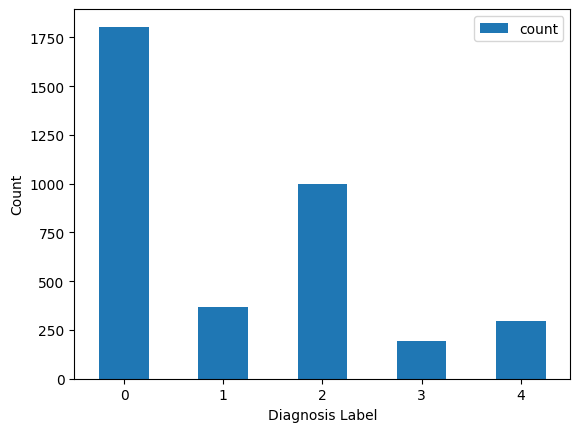

In [130]:
df_train = pd.read_csv(os.path.join(dataset_dir, 'train.csv'))

x = df_train['id_code']
y = df_train['diagnosis']
plot_counts(y)

0    1805
2    1487
1     370
Name: diagnosis, dtype: int64


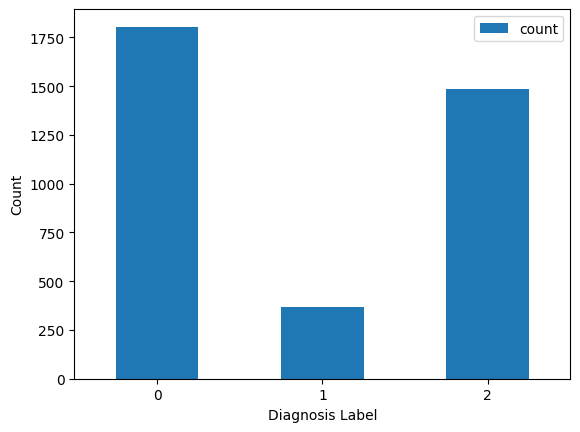

In [131]:
# Replace all diagnosis values of 3 and 4 with 2
y = y.apply(lambda category: 2 if category > 2 else category)
x, y = shuffle(x, y, random_state=8)
plot_counts(y)

In [ ]:
y = to_categorical(y, num_classes=NUM_CLASSES)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SPLIT,
                                                  stratify=y, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VAL_SPLIT,
                                                  stratify=y_train, random_state=42)

# Data Preprocessing Functions

In [42]:
class DRImagePreprocessor:
    """
    Preprocess the images to remove black borders
    and improve contrast using Y channel and CLAHE
    """
    def __init__(self, target_size=256, add_clahe=True, clip_limit=4, tile_grid_size=(40, 40), all_clahe=False):
        '''
        Initialise the image preprocessor
        with the given settings
        '''
        self.target_size = target_size
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.add_clahe = add_clahe
        self.all_clahe = all_clahe

    def preprocess_image(self, image_path):
        """
        Preprocess the image
        """
        try:
            # Read the image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Crop the image to remove black borders
            cropped_rgb_image = self.remove_black_borders(image)

            if self.add_clahe:
                equalised_image = self.apply_clahe(
                    cropped_rgb_image, self.clip_limit, self.tile_grid_size, self.all_clahe)

                # Resize the image to target size
                resized_image = cv2.resize(equalised_image, (self.target_size, self.target_size))
            else:
                # Resize the image to target size
                resized_image = cv2.resize(cropped_rgb_image, (self.target_size, self.target_size))

            return resized_image

        except Exception as e:
            print("Error processing image: ")
            print(e)


    def remove_black_borders(self, image):
        """
        Crop the image to remove black borders
        """
        green_channel_image =  image[:, :, 1]

        # Find the contours in the green channel
        contours, _ = cv2.findContours(
            green_channel_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the bounding rectangle of the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Create a mask with the same size as the bounding rectangle
        mask = np.zeros((h, w), np.uint8)

        # Draw the largest contour on the mask
        cv2.drawContours(mask, [largest_contour - [x, y]], 0, 255, -1)

        # Convert the mask to a 3 channel image
        mask_3_channel = cv2.merge([mask, mask, mask])

        # Crop the image using the mask
        cropped_image = cv2.bitwise_and(image[y:y+h, x:x+w], mask_3_channel)

        return cropped_image


    def apply_clahe(self, image, clip_limit=4, tile_grid_size=(40,40), all_clahe=False):
        """
        Preprocess the image
        """
        try:
            # Extract the y channel from the cropped rgb image
            yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            cropped_y_channel_image = yuv_image[:, :, 0]

            # Apply CLAHE to the y channel of the cropped image
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
            enhanced_y_channel = clahe.apply(cropped_y_channel_image)

            if all_clahe:
                cropped_u_channel = yuv_image[:, :, 1]
                enhanced_u_channel = clahe.apply(cropped_u_channel)
                cropped_v_channel = yuv_image[:, :, 2]
                enhanced_v_channel = clahe.apply(cropped_v_channel)
                
                enhanced_yuv_image = np.stack([enhanced_y_channel, enhanced_u_channel, enhanced_v_channel], axis=-1)

                # Convert YUV to RGB
                enhanced_rgb_image = cv2.cvtColor(enhanced_yuv_image, cv2.COLOR_YUV2RGB)

                return enhanced_rgb_image
            else:
                # Convert the y channel image to grayscale
                enhanced_grayscale_image = cv2.convertScaleAbs(enhanced_y_channel, alpha=(255/219))
            
                # Repeat the equalised grayscale for all 3-channels
                enhanced_grayscale_3_channels = np.stack((enhanced_grayscale_image,) * 3, axis=-1)

                return enhanced_grayscale_3_channels

        except Exception as e:
            print("Error processing image: ", e)

In [43]:
class CustomImageGenerator(Sequence):
    def __init__(self, image_filenames, labels, batch_size, image_size, train_dir, model_name='',
                 image_file_ext='.png', is_train=False, mix=False, augment=False, apply_clahe=True,
                 clip_limit=2, tile_grid_size=(8, 8), all_clahe=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.model_name = model_name
        self.train_dir = train_dir
        self.image_file_ext = image_file_ext
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix
        self.dr_preprocessor = DRImagePreprocessor(self.image_size, apply_clahe, clip_limit=clip_limit, tile_grid_size=tile_grid_size, all_clahe=all_clahe)


    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))


    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.generate_train_batch(batch_x, batch_y)
        return self.generate_validation_batch(batch_x, batch_y)


    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
    

    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y


    def generate_train_batch(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            image_path = os.path.join(self.train_dir, sample + self.image_file_ext)

            # Apply eye image specific preprocessing
            img = self.dr_preprocessor.preprocess_image(image_path)
            
            if(self.is_augment):
                img = ImageDataGenerator().apply_transform(img, 
                                                           transform_parameters={
                                                               'theta': 180, 'tx': 0.2, 'ty': 0.2, 
                                                               'shear': 20, 'flip_horizontal': True
                                                            })
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32)
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def generate_validation_batch(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            image_path = os.path.join(self.train_dir, sample + self.image_file_ext)
            
            # Apply eye image specific preprocessing
            img = self.dr_preprocessor.preprocess_image(image_path)

            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32)
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y

In [44]:
# Function to load features and labels for ensemble model
def load_features_and_labels(image_filenames, labels, image_size, train_dir, image_file_ext='.png', is_train=False, augment=True,
                 apply_clahe=True, clip_limit=4, tile_grid_size=(40, 40), all_clahe=True):
    if (is_train):
        image_filenames, labels = shuffle(image_filenames, labels)
    
    dr_preprocessor = DRImagePreprocessor(image_size, apply_clahe, clip_limit=clip_limit, tile_grid_size=tile_grid_size, all_clahe=all_clahe)
    
    images = []
    for img_name in tqdm(image_filenames):
        image_path = os.path.join(train_dir, img_name + image_file_ext)

        # Apply eye image specific preprocessing
        img = dr_preprocessor.preprocess_image(image_path)

        if(augment):
            img = ImageDataGenerator().apply_transform(img, 
                                                       transform_parameters={
                                                           'theta': 180, 'tx': 0.2, 'ty': 0.2, 
                                                           'shear': 20, 'flip_horizontal': True
                                                        })
        images.append(img)
    images = np.array(images, np.float32)
    y = np.array(labels, np.float32)
    
    return images, y

In [ ]:
def display_original_vs_cropped(image_path):
    preprocessor = DRImagePreprocessor(target_size=128, add_clahe=False)
    rgb_image = preprocessor.preprocess_image(image_path)

    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    
    # remove the x and y ticks
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        
    axes[0].set_title('Original Image', fontsize=20)
    axes[1].set_title('RGB RoI Cropped Image', fontsize=20)
    axes[0].imshow(original_image)
    axes[1].imshow(rgb_image)

In [ ]:
def display_original_vs_clahe(image_path, clip_limit=2, tile_grid_size=(8, 8), all_clahe=False):
    preprocessor = DRImagePreprocessor(target_size=128, add_clahe=False)
    rgb_image = preprocessor.preprocess_image(image_path)
    
    preprocessor_with_clahe = DRImagePreprocessor(target_size=128, add_clahe=True, 
                                                  clip_limit=clip_limit, tile_grid_size=tile_grid_size)
    clahe_image = preprocessor_with_clahe.preprocess_image(image_path)
    
    preprocessor_with_all_clahe = DRImagePreprocessor(target_size=128, add_clahe=True, 
                                                  clip_limit=clip_limit, tile_grid_size=tile_grid_size,
                                                  all_clahe=all_clahe)
    all_clahe_image = preprocessor_with_all_clahe.preprocess_image(image_path)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 15))
    
    # remove the x and y ticks
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        
    axes[0].set_title('RGB RoI Cropped Image', fontsize=20)
    axes[1].set_title('CLAHE (Y Channel)', fontsize=20)
    axes[2].set_title('CLAHE (All Channels)', fontsize=20)
    axes[0].imshow(rgb_image)
    axes[1].imshow(clahe_image)
    axes[2].imshow(all_clahe_image)

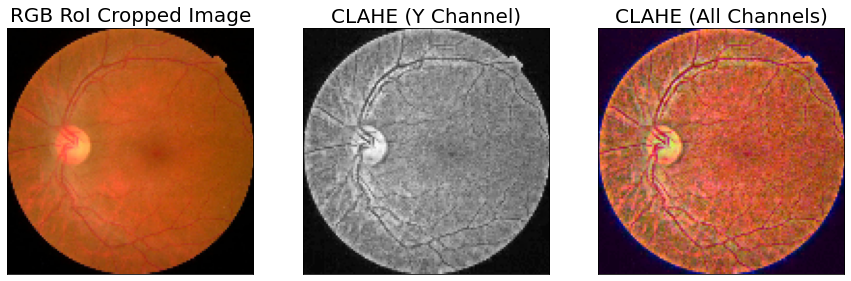

In [ ]:
display_original_vs_clahe(os.path.join(train_images_dir, x_train[0] + '.png'),
                         clip_limit=4, tile_grid_size=(40, 40), all_clahe=True)

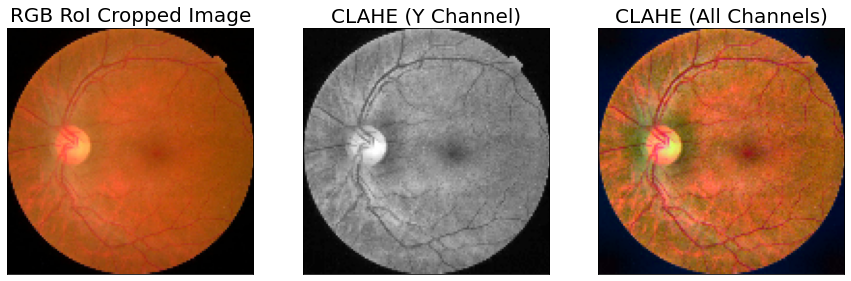

In [ ]:
display_original_vs_clahe(os.path.join(train_images_dir, x_train[0] + '.png'),
                         clip_limit=2, tile_grid_size=(8, 8), all_clahe=True)

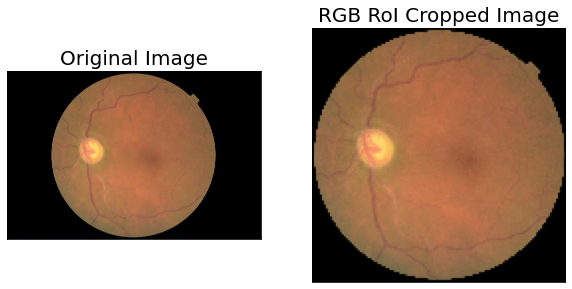

In [ ]:
display_original_vs_cropped('/content/drive/MyDrive/Colab Notebooks/original_datasets/diabetic-retinopathy-detection/train/train/15_left.jpeg')

# Training Functions

In [10]:
def build_model(base_model, is_trainable, model_name, image_size=224, num_classes=3):
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = is_trainable
        
    # Create new model on top
    inputs = tf.keras.Input(shape=(image_size, image_size, 3))

    if model_name == 'ResNet50V2':
        x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
        x = base_model(x, training=False)
    elif model_name == 'EfficientNetV2B3' or model_name == 'EfficientNetV2S':
        x = base_model(inputs, training=False)
    elif model_name == 'VGG19':
        x = tf.keras.applications.vgg19.preprocess_input(inputs)
        x = base_model(x, training=False)
    elif model_name == 'VGG16':
        x = tf.keras.applications.vgg16.preprocess_input(inputs)
        x = base_model(x, training=False)
    elif model_name == 'InceptionResnetV2':
        x = tf.keras.applications.inception_resnet_v2.preprocess_input(inputs)
        x = base_model(x, training=False)
    elif model_name == 'InceptionV3':
        x = tf.keras.applications.inception_v3.preprocess_input(inputs)
        x = base_model(x, training=False)
    elif model_name == 'EfficientNetB4':
        x = tf.keras.applications.efficientnet.preprocess_input(inputs)
        x = base_model(x, training=False)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=predictions)

    # Print summary
    print('========================= MODEL SUMMARY =========================')
    print(model.summary())
    
    return model

In [11]:
def compile_model(model, optimizer, 
                  loss=tfa.losses.WeightedKappaLoss(num_classes=3, weightage='quadratic')):
    ''' Compiles a model '''
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            tfa.metrics.CohenKappa(num_classes=3, weightage='quadratic', name='cohen_kappa'),
            tf.keras.metrics.Recall(name="sensitivity"),
            tfa.metrics.F1Score(num_classes=3, average='macro', name='f1_score'),
            tf.keras.metrics.AUC(name="auc"),
            tfa.metrics.MultiLabelConfusionMatrix(num_classes=3)
        ]
    )
    return model

In [12]:
def get_class_weights(y_train):
    # convert from one-hot encoding to ints
    y_train_ints = [np.argmax(label) for label in y_train]

    # compute class weights
    class_weights = class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_train_ints), y=y_train_ints)

    # set class weights for Keras
    class_weights_dict = dict(enumerate(class_weights))

    return class_weights_dict

In [13]:
def train_freezed_pretrained_model(
    model, model_name, batch_size, epochs=20, initial_epoch=0, 
    initial_value_threshold=None, additional_callbacks=[]):
    if not os.path.exists(os.path.join(outputs_dir, model_name)):
        os.makedirs(os.path.join(outputs_dir, model_name))

    model_history = model.fit(
        train_generator,
        steps_per_epoch=np.ceil(float(len(x_train)) / float(batch_size)),
        validation_data=val_generator,
        validation_steps=np.ceil(float(len(x_val)) / float(batch_size)),
        class_weight=get_class_weights(y_train),
        epochs=epochs,
        initial_epoch=initial_epoch,
        workers=2, 
        use_multiprocessing=True,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.TerminateOnNaN(),
            tf.keras.callbacks.CSVLogger(os.path.join(outputs_dir, model_name, f'{model_name}_trainableFalse_training.log'), separator=',', append=True),
            tf.keras.callbacks.ModelCheckpoint(os.path.join(outputs_dir, model_name, f'{model_name}_trainableFalse'), 
                                 monitor='val_loss', verbose=1, 
                                 save_best_only=True, mode='min', initial_value_threshold=initial_value_threshold)
        ] + additional_callbacks
    )
    return model_history, model

In [14]:
def plot_training_history(history, from_csv=False):
    '''
    Plots the training history
    '''
    if from_csv:
        history.history = history
        
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History')
    axs[0, 0].plot(history.history['cohen_kappa'])
    axs[0, 0].plot(history.history['val_cohen_kappa'])
    axs[0, 0].set_title('Model Accuracy (Cohen Kappa Score)')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['Train', 'Validation'], loc='upper left')
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['Train', 'Validation'], loc='upper left')
    axs[1, 0].plot(history.history['sensitivity'])
    axs[1, 0].plot(history.history['val_sensitivity'])
    axs[1, 0].set_title('Model Sensitivity')
    axs[1, 0].set_ylabel('Sensitivity')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['Train', 'Validation'], loc='upper left')
    axs[1, 1].plot(history.history['f1_score'])
    axs[1, 1].plot(history.history['val_f1_score'])
    axs[1, 1].set_title('Model F1 Score')
    axs[1, 1].set_ylabel('F1 Score')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [15]:
def train_unfreezed_model(
    model, model_name, batch_size, epochs=30, initial_epoch=0, 
    initial_value_threshold=None, additional_callbacks=[]):
    if not os.path.exists(os.path.join(outputs_dir, model_name)):
        os.makedirs(os.path.join(outputs_dir, model_name))

    model_history = model.fit(
        train_generator,
        steps_per_epoch=np.ceil(float(len(x_train)) / float(batch_size)),
        validation_data=val_generator,
        validation_steps=np.ceil(float(len(x_val)) / float(batch_size)),
        class_weight=get_class_weights(y_train),
        epochs=epochs,
        initial_epoch=initial_epoch,
        workers=1, 
        use_multiprocessing=False,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.TerminateOnNaN(),
            tf.keras.callbacks.CSVLogger(os.path.join(outputs_dir, model_name, f'{model_name}_trainableTrue_training.log'), separator=',', append=True),
            tf.keras.callbacks.ModelCheckpoint(os.path.join(outputs_dir, model_name, f'{model_name}_trainableTrue'), 
                                 monitor='val_loss', verbose=1, 
                                 save_best_only=True, mode='min', initial_value_threshold=initial_value_threshold),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='min', min_delta=0.0001),
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=9)
        ] + additional_callbacks
    )
    return model_history, model

# VGG16 - NoCLAHE, Batch Size 32, Image Size 128

In [152]:
BATCH_SIZE = 32
IMAGE_SIZE = 128

train_generator = CustomImageGenerator(x_train, y_train, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, 
                                       train_dir=train_images_dir, is_train=True, augment=True,
                                       apply_clahe=False)

val_generator = CustomImageGenerator(x_val, y_val, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, 
                                     train_dir=train_images_dir, is_train=False,
                                     apply_clahe=False)

In [154]:
model_name = 'VGG16_32_128_NoCLAHE'

vgg16_img128_base_model = VGG16(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    classes=NUM_CLASSES
)

vgg16_bs32_img128 = build_model(
    vgg16_img128_base_model, 
    is_trainable=False, 
    image_size=IMAGE_SIZE, 
    num_classes=NUM_CLASSES, 
    model_name='VGG16'
)

========================= MODEL SUMMARY =========================
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                  

In [ ]:
vgg16_bs32_img128 = compile_model(vgg16_bs32_img128, optimizer=Adam())

vgg16_bs32_img128_history, vgg16_bs32_img128 = train_freezed_pretrained_model(
    vgg16_bs32_img128, model_name, batch_size=BATCH_SIZE)

Epoch 1/20


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


92/92 [==============================] - ETA: 0s - loss: -1.6637 - cohen_kappa: 0.7838 - sensitivity: 0.8132 - f1_score: 0.5928 - auc: 0.8834 - Multilabel_confusion_matrix: 732.2500 
Epoch 1: val_loss improved from inf to -0.42057, saving model to /content/drive/MyDrive/Colab Notebooks/aptos_results2/VGG16_32_128_NoCLAHE/VGG16_32_128_NoCLAHE_trainableFalse


92/92 [==============================] - 1683s 18s/step - loss: -1.6637 - cohen_kappa: 0.7838 - sensitivity: 0.8132 - f1_score: 0.5928 - auc: 0.8834 - Multilabel_confusion_matrix: 732.2500 - val_loss: -0.4206 - val_cohen_kappa: 0.3625 - val_sensitivity: 0.6398 - val_f1_score: 0.4189 - val_auc: 0.7568 - val_Multilabel_confusion_matrix: 183.2500
Epoch 2/20
92/92 [==============================] - ETA: 0s - loss: -1.7014 - cohen_kappa: 0.7828 - sensitivity: 0.8218 - f1_score: 0.5744 - auc: 0.8798 - Multilabel_confusion_matrix: 732.2500 
Epoch 2: val_loss improved from -0.42057 to -1.77132, saving model to /content/drive/MyDrive/Colab Notebooks/aptos_results2/VGG16_32_128_NoCLAHE/VGG16_32_128_NoCLAHE_trainableFalse


92/92 [==============================] - 1451s 16s/step - loss: -1.7014 - cohen_kappa: 0.7828 - sensitivity: 0.8218 - f1_score: 0.5744 - auc: 0.8798 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.7713 - val_cohen_kappa: 0.8070 - val_sensitivity: 0.8336 - val_f1_score: 0.5829 - val_auc: 0.8917 - val_Multilabel_confusion_matrix: 183.2500
Epoch 3/20
92/92 [==============================] - ETA: 0s - loss: -1.8664 - cohen_kappa: 0.8187 - sensitivity: 0.8382 - f1_score: 0.5870 - auc: 0.8863 - Multilabel_confusion_matrix: 732.2500 
Epoch 3: val_loss did not improve from -1.77132
92/92 [==============================] - 1506s 16s/step - loss: -1.8664 - cohen_kappa: 0.8187 - sensitivity: 0.8382 - f1_score: 0.5870 - auc: 0.8863 - Multilabel_confusion_matrix: 732.2500 - val_loss: -0.8844 - val_cohen_kappa: 0.5809 - val_sensitivity: 0.7340 - val_f1_score: 0.5080 - val_auc: 0.8122 - val_Multilabel_confusion_matrix: 183.2500
Epoch 4/20
92/92 [==============================] - ETA: 0s - loss

92/92 [==============================] - 1448s 16s/step - loss: -1.9715 - cohen_kappa: 0.8433 - sensitivity: 0.8501 - f1_score: 0.5947 - auc: 0.8916 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.3997 - val_cohen_kappa: 0.8386 - val_sensitivity: 0.8472 - val_f1_score: 0.5945 - val_auc: 0.8967 - val_Multilabel_confusion_matrix: 183.2500
Epoch 5/20
92/92 [==============================] - ETA: 0s - loss: -2.0284 - cohen_kappa: 0.8159 - sensitivity: 0.8365 - f1_score: 0.5866 - auc: 0.8824 - Multilabel_confusion_matrix: 732.2500 
Epoch 5: val_loss did not improve from -2.39971
92/92 [==============================] - 1526s 16s/step - loss: -2.0284 - cohen_kappa: 0.8159 - sensitivity: 0.8365 - f1_score: 0.5866 - auc: 0.8824 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.9553 - val_cohen_kappa: 0.8505 - val_sensitivity: 0.8540 - val_f1_score: 0.5979 - val_auc: 0.8936 - val_Multilabel_confusion_matrix: 183.2500
Epoch 6/20
92/92 [==============================] - ETA: 0s - loss

92/92 [==============================] - 1428s 15s/step - loss: -2.4197 - cohen_kappa: 0.8679 - sensitivity: 0.8614 - f1_score: 0.6036 - auc: 0.8973 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.5295 - val_cohen_kappa: 0.8496 - val_sensitivity: 0.8527 - val_f1_score: 0.5979 - val_auc: 0.8913 - val_Multilabel_confusion_matrix: 183.2500
Epoch 17/20
92/92 [==============================] - ETA: 0s - loss: -2.0897 - cohen_kappa: 0.8450 - sensitivity: 0.8351 - f1_score: 0.6213 - auc: 0.8826 - Multilabel_confusion_matrix: 732.2500 
Epoch 17: val_loss did not improve from -2.52950
92/92 [==============================] - 1477s 16s/step - loss: -2.0897 - cohen_kappa: 0.8450 - sensitivity: 0.8351 - f1_score: 0.6213 - auc: 0.8826 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.6840 - val_cohen_kappa: 0.7939 - val_sensitivity: 0.8267 - val_f1_score: 0.5798 - val_auc: 0.8740 - val_Multilabel_confusion_matrix: 183.2500
Epoch 18/20
92/92 [==============================] - ETA: 0s - l

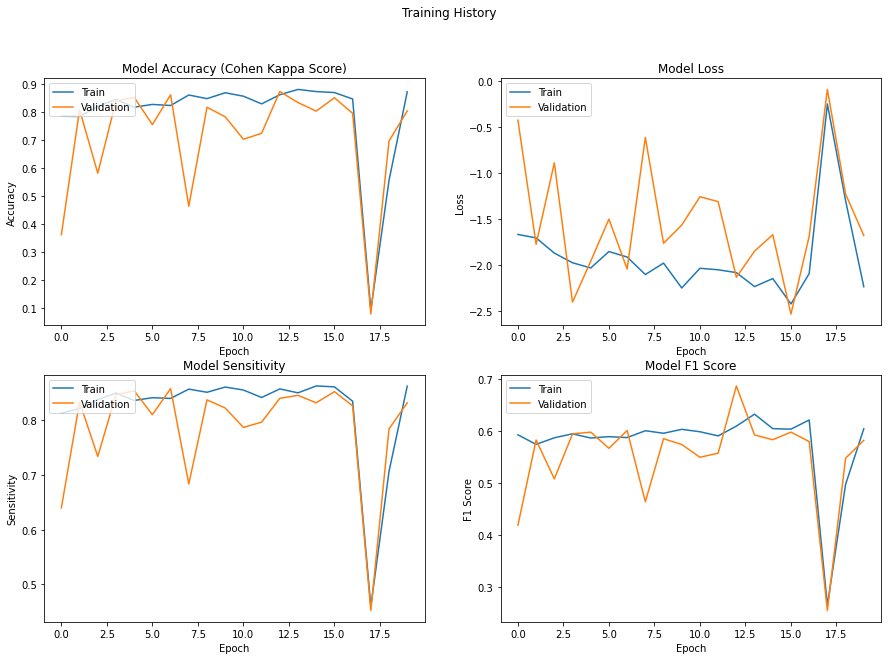

In [ ]:
plot_training_history(vgg16_bs32_img128_history)

# VGG16 - CLAHE, Batch Size 32, Image Size 128

In [15]:
BATCH_SIZE = 32
IMAGE_SIZE = 128

train_generator = CustomImageGenerator(x_train, y_train, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, 
                                       train_dir=train_images_dir, is_train=True, augment=True,
                                       apply_clahe=True)

val_generator = CustomImageGenerator(x_val, y_val, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, 
                                     train_dir=train_images_dir, is_train=False,
                                     apply_clahe=True)

In [16]:
model_name = 'VGG16_32_128_CLAHE'

vgg16_img128_base_model = VGG16(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    classes=NUM_CLASSES
)

vgg16_bs32_img128 = build_model(
    vgg16_img128_base_model, 
    is_trainable=False, 
    image_size=IMAGE_SIZE, 
    num_classes=NUM_CLASSES, 
    model_name='VGG16'
)

========================= MODEL SUMMARY =========================
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                             

In [18]:
vgg16_bs32_img128 = compile_model(vgg16_bs32_img128, optimizer=Adam())

vgg16_bs32_img128_history, vgg16_bs32_img128 = train_freezed_pretrained_model(
    vgg16_bs32_img128, model_name, batch_size=BATCH_SIZE)

Epoch 1/20
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
92/92 [==============================] - ETA: 0s - loss: -0.2435 - cohen_kappa: 0.2166 - sensitivity: 0.2410 - f1_score: 0.2147 - auc: 0.4276 - Multilabel_confusion_matrix: 732.2500
Epoch 1: val_loss improved from inf to -0.55194, saving model to ./aptos_results2/VGG16_32_128_CLAHE/VGG16_32_128_CLAHE_trainableFalse


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_CLAHE/VGG16_32_128_CLAHE_trainableFalse/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_CLAHE/VGG16_32_128_CLAHE_trainableFalse/assets


92/92 [==============================] - 687s 7s/step - loss: -0.2435 - cohen_kappa: 0.2166 - sensitivity: 0.2410 - f1_score: 0.2147 - auc: 0.4276 - Multilabel_confusion_matrix: 732.2500 - val_loss: -0.5519 - val_cohen_kappa: 0.4305 - val_sensitivity: 0.5334 - val_f1_score: 0.3607 - val_auc: 0.6517 - val_Multilabel_confusion_matrix: 183.2500
Epoch 2/20
92/92 [==============================] - ETA: 0s - loss: -0.8059 - cohen_kappa: 0.5575 - sensitivity: 0.5162 - f1_score: 0.3900 - auc: 0.6399 - Multilabel_confusion_matrix: 732.2500
Epoch 2: val_loss improved from -0.55194 to -0.91975, saving model to ./aptos_results2/VGG16_32_128_CLAHE/VGG16_32_128_CLAHE_trainableFalse


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_CLAHE/VGG16_32_128_CLAHE_trainableFalse/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_CLAHE/VGG16_32_128_CLAHE_trainableFalse/assets


92/92 [==============================] - 744s 8s/step - loss: -0.8059 - cohen_kappa: 0.5575 - sensitivity: 0.5162 - f1_score: 0.3900 - auc: 0.6399 - Multilabel_confusion_matrix: 732.2500 - val_loss: -0.9197 - val_cohen_kappa: 0.6063 - val_sensitivity: 0.5266 - val_f1_score: 0.4007 - val_auc: 0.6487 - val_Multilabel_confusion_matrix: 183.2500
Epoch 3/20
92/92 [==============================] - ETA: 0s - loss: -0.8751 - cohen_kappa: 0.5832 - sensitivity: 0.5353 - f1_score: 0.3995 - auc: 0.6536 - Multilabel_confusion_matrix: 732.2500
Epoch 3: val_loss did not improve from -0.91975
92/92 [==============================] - 679s 7s/step - loss: -0.8751 - cohen_kappa: 0.5832 - sensitivity: 0.5353 - f1_score: 0.3995 - auc: 0.6536 - Multilabel_confusion_matrix: 732.2500 - val_loss: -0.4858 - val_cohen_kappa: 0.3929 - val_sensitivity: 0.5334 - val_f1_score: 0.3470 - val_auc: 0.6510 - val_Multilabel_confusion_matrix: 183.2500
Epoch 4/20
92/92 [==============================] - ETA: 0s - loss: -0.

INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_CLAHE/VGG16_32_128_CLAHE_trainableFalse/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_CLAHE/VGG16_32_128_CLAHE_trainableFalse/assets


92/92 [==============================] - 686s 7s/step - loss: -0.9747 - cohen_kappa: 0.6202 - sensitivity: 0.5548 - f1_score: 0.4136 - auc: 0.6669 - Multilabel_confusion_matrix: 732.2500 - val_loss: -0.9720 - val_cohen_kappa: 0.6228 - val_sensitivity: 0.5484 - val_f1_score: 0.4074 - val_auc: 0.6608 - val_Multilabel_confusion_matrix: 183.2500
Epoch 17/20
92/92 [==============================] - ETA: 0s - loss: -0.9490 - cohen_kappa: 0.6100 - sensitivity: 0.5336 - f1_score: 0.4045 - auc: 0.6507 - Multilabel_confusion_matrix: 732.2500
Epoch 17: val_loss did not improve from -0.97197
92/92 [==============================] - 688s 7s/step - loss: -0.9490 - cohen_kappa: 0.6100 - sensitivity: 0.5336 - f1_score: 0.4045 - auc: 0.6507 - Multilabel_confusion_matrix: 732.2500 - val_loss: -0.9643 - val_cohen_kappa: 0.6183 - val_sensitivity: 0.5580 - val_f1_score: 0.4068 - val_auc: 0.6683 - val_Multilabel_confusion_matrix: 183.2500
Epoch 18/20
92/92 [==============================] - ETA: 0s - loss: 

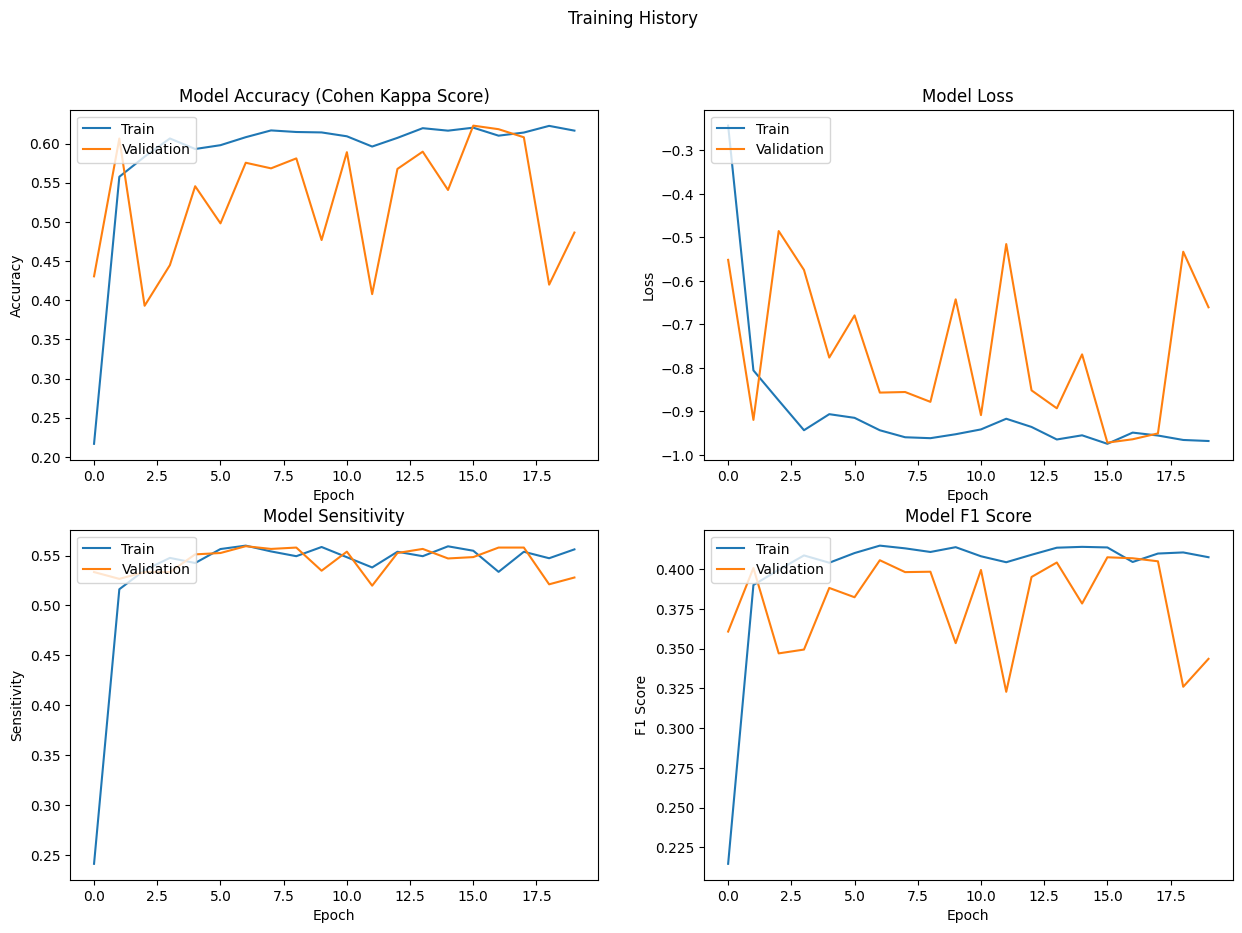

In [19]:
plot_training_history(vgg16_bs32_img128_history)

# VGG16 - CLAHE(4, 40), Batch Size 32, Image Size 128

In [27]:
BATCH_SIZE = 32
IMAGE_SIZE = 128

train_generator = CustomImageGenerator(x_train, y_train, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, 
                                       train_dir=train_images_dir, is_train=True, augment=True,
                                       apply_clahe=True, clip_limit=4, tile_grid_size=(40, 40))

val_generator = CustomImageGenerator(x_val, y_val, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, 
                                     train_dir=train_images_dir, is_train=False,
                                     apply_clahe=True, clip_limit=4, tile_grid_size=(40, 40))

In [27]:
model_name = 'VGG16_32_128_CLAHE_4_40'

vgg16_img128_base_model = VGG16(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    classes=NUM_CLASSES
)

vgg16_bs32_img128_clahe4 = build_model(
    vgg16_img128_base_model, 
    is_trainable=False, 
    image_size=IMAGE_SIZE, 
    num_classes=NUM_CLASSES, 
    model_name='VGG16'
)

========================= MODEL SUMMARY =========================
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                  

In [28]:
vgg16_bs32_img128_clahe4 = compile_model(vgg16_bs32_img128_clahe4, optimizer=Adam())

vgg16_bs32_img128_clahe4_history, vgg16_bs32_img128_clahe4 = train_freezed_pretrained_model(
    vgg16_bs32_img128_clahe4, model_name, batch_size=BATCH_SIZE)

Epoch 1/20
92/92 [==============================] - ETA: 0s - loss: -1.4530 - cohen_kappa: 0.7201 - sensitivity: 0.7760 - f1_score: 0.5534 - auc: 0.8582 - Multilabel_confusion_matrix: 732.2500
Epoch 1: val_loss improved from inf to -1.96362, saving model to ./aptos_results2/VGG16_32_128_CLAHE_4_40/VGG16_32_128_CLAHE_4_40_trainableFalse


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_CLAHE_4_40/VGG16_32_128_CLAHE_4_40_trainableFalse/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_CLAHE_4_40/VGG16_32_128_CLAHE_4_40_trainableFalse/assets


92/92 [==============================] - 716s 8s/step - loss: -1.4530 - cohen_kappa: 0.7201 - sensitivity: 0.7760 - f1_score: 0.5534 - auc: 0.8582 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.9636 - val_cohen_kappa: 0.8494 - val_sensitivity: 0.8527 - val_f1_score: 0.5978 - val_auc: 0.9030 - val_Multilabel_confusion_matrix: 183.2500
Epoch 2/20
92/92 [==============================] - ETA: 0s - loss: -1.4450 - cohen_kappa: 0.6996 - sensitivity: 0.7835 - f1_score: 0.5471 - auc: 0.8473 - Multilabel_confusion_matrix: 732.2500
Epoch 2: val_loss did not improve from -1.96362
92/92 [==============================] - 700s 8s/step - loss: -1.4450 - cohen_kappa: 0.6996 - sensitivity: 0.7835 - f1_score: 0.5471 - auc: 0.8473 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.6056 - val_cohen_kappa: 0.7940 - val_sensitivity: 0.8281 - val_f1_score: 0.5798 - val_auc: 0.8846 - val_Multilabel_confusion_matrix: 183.2500
Epoch 3/20
92/92 [==============================] - ETA: 0s - loss: -1.

INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_CLAHE_4_40/VGG16_32_128_CLAHE_4_40_trainableFalse/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_CLAHE_4_40/VGG16_32_128_CLAHE_4_40_trainableFalse/assets


92/92 [==============================] - 705s 8s/step - loss: -1.8175 - cohen_kappa: 0.8136 - sensitivity: 0.8358 - f1_score: 0.5854 - auc: 0.8812 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.1511 - val_cohen_kappa: 0.8747 - val_sensitivity: 0.8649 - val_f1_score: 0.6058 - val_auc: 0.9010 - val_Multilabel_confusion_matrix: 183.2500
Epoch 9/20
92/92 [==============================] - ETA: 0s - loss: -2.0222 - cohen_kappa: 0.8527 - sensitivity: 0.8546 - f1_score: 0.5980 - auc: 0.8935 - Multilabel_confusion_matrix: 732.2500
Epoch 9: val_loss improved from -2.15106 to -2.22989, saving model to ./aptos_results2/VGG16_32_128_CLAHE_4_40/VGG16_32_128_CLAHE_4_40_trainableFalse


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_CLAHE_4_40/VGG16_32_128_CLAHE_4_40_trainableFalse/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_CLAHE_4_40/VGG16_32_128_CLAHE_4_40_trainableFalse/assets


92/92 [==============================] - 714s 8s/step - loss: -2.0222 - cohen_kappa: 0.8527 - sensitivity: 0.8546 - f1_score: 0.5980 - auc: 0.8935 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.2299 - val_cohen_kappa: 0.8890 - val_sensitivity: 0.8718 - val_f1_score: 0.6107 - val_auc: 0.9052 - val_Multilabel_confusion_matrix: 183.2500
Epoch 10/20
92/92 [==============================] - ETA: 0s - loss: -1.6137 - cohen_kappa: 0.7566 - sensitivity: 0.8105 - f1_score: 0.5654 - auc: 0.8616 - Multilabel_confusion_matrix: 732.2500
Epoch 10: val_loss did not improve from -2.22989
92/92 [==============================] - 683s 7s/step - loss: -1.6137 - cohen_kappa: 0.7566 - sensitivity: 0.8105 - f1_score: 0.5654 - auc: 0.8616 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.7863 - val_cohen_kappa: 0.8180 - val_sensitivity: 0.8390 - val_f1_score: 0.5862 - val_auc: 0.8856 - val_Multilabel_confusion_matrix: 183.2500
Epoch 11/20
92/92 [==============================] - ETA: 0s - loss: 

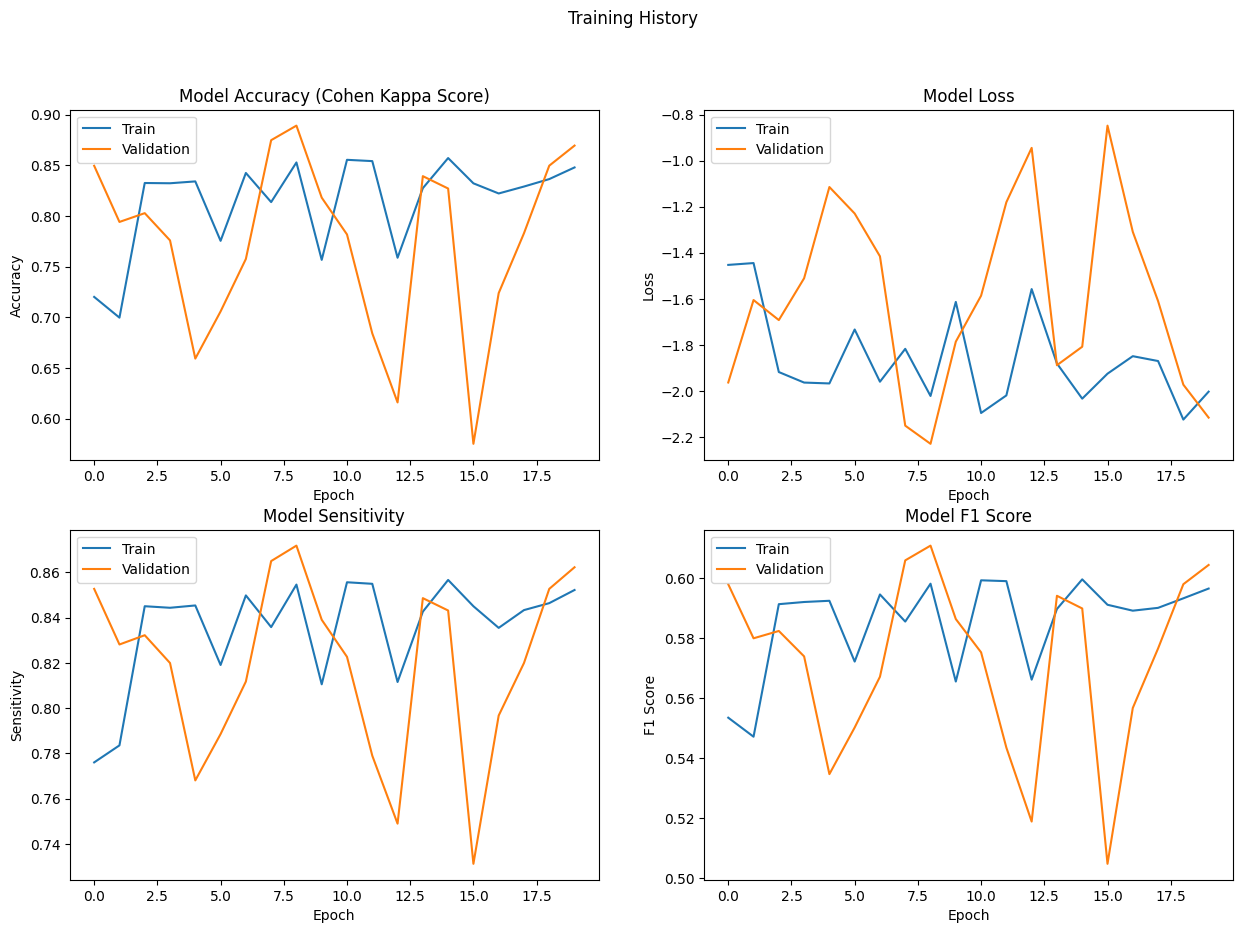

In [29]:
plot_training_history(vgg16_bs32_img128_clahe4_history)

# VGG16 - CLAHE(4, 40) 3 channels, Batch Size 32, Image Size 128

In [43]:
BATCH_SIZE = 32
IMAGE_SIZE = 128

train_generator = CustomImageGenerator(x_train, y_train, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, 
                                       train_dir=train_images_dir, is_train=True, augment=True,
                                       apply_clahe=True, clip_limit=4, tile_grid_size=(40, 40),
                                       all_clahe=True)

val_generator = CustomImageGenerator(x_val, y_val, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, 
                                     train_dir=train_images_dir, is_train=False,
                                     apply_clahe=True, clip_limit=4, tile_grid_size=(40, 40),
                                     all_clahe=True)

In [34]:
model_name = 'VGG16_32_128_ALLCLAHE_4_40'

vgg16_img128_base_model = VGG16(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    classes=NUM_CLASSES
)

vgg16_bs32_img128_allCLAHE4 = build_model(
    vgg16_img128_base_model, 
    is_trainable=False, 
    image_size=IMAGE_SIZE, 
    num_classes=NUM_CLASSES, 
    model_name='VGG16'
)

========================= MODEL SUMMARY =========================
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                  

In [35]:
vgg16_bs32_img128_allCLAHE4 = compile_model(vgg16_bs32_img128_allCLAHE4, optimizer=Adam())

vgg16_bs32_img128_allCLAHE4_history, vgg16_bs32_img128_allCLAHE4 = train_freezed_pretrained_model(
    vgg16_bs32_img128_allCLAHE4, model_name, batch_size=BATCH_SIZE)

Epoch 1/20
92/92 [==============================] - ETA: 0s - loss: -1.4708 - cohen_kappa: 0.7335 - sensitivity: 0.7491 - f1_score: 0.5522 - auc: 0.8367 - Multilabel_confusion_matrix: 732.2500
Epoch 1: val_loss improved from inf to -1.48591, saving model to ./aptos_results2/VGG16_32_128_ALLCLAHE_4_40/VGG16_32_128_ALLCLAHE_4_40_trainableFalse


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_ALLCLAHE_4_40/VGG16_32_128_ALLCLAHE_4_40_trainableFalse/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_ALLCLAHE_4_40/VGG16_32_128_ALLCLAHE_4_40_trainableFalse/assets


92/92 [==============================] - 840s 9s/step - loss: -1.4708 - cohen_kappa: 0.7335 - sensitivity: 0.7491 - f1_score: 0.5522 - auc: 0.8367 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.4859 - val_cohen_kappa: 0.7680 - val_sensitivity: 0.8158 - val_f1_score: 0.5700 - val_auc: 0.8821 - val_Multilabel_confusion_matrix: 183.2500
Epoch 2/20
92/92 [==============================] - ETA: 0s - loss: -1.6230 - cohen_kappa: 0.7802 - sensitivity: 0.8194 - f1_score: 0.5732 - auc: 0.8743 - Multilabel_confusion_matrix: 732.2500
Epoch 2: val_loss did not improve from -1.48591
92/92 [==============================] - 830s 9s/step - loss: -1.6230 - cohen_kappa: 0.7802 - sensitivity: 0.8194 - f1_score: 0.5732 - auc: 0.8743 - Multilabel_confusion_matrix: 732.2500 - val_loss: -0.5993 - val_cohen_kappa: 0.4475 - val_sensitivity: 0.6753 - val_f1_score: 0.4541 - val_auc: 0.7785 - val_Multilabel_confusion_matrix: 183.2500
Epoch 3/20
92/92 [==============================] - ETA: 0s - loss: -1.

INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_ALLCLAHE_4_40/VGG16_32_128_ALLCLAHE_4_40_trainableFalse/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_ALLCLAHE_4_40/VGG16_32_128_ALLCLAHE_4_40_trainableFalse/assets


92/92 [==============================] - 843s 9s/step - loss: -1.9544 - cohen_kappa: 0.8329 - sensitivity: 0.8453 - f1_score: 0.5910 - auc: 0.8870 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.7665 - val_cohen_kappa: 0.8240 - val_sensitivity: 0.8417 - val_f1_score: 0.5883 - val_auc: 0.8861 - val_Multilabel_confusion_matrix: 183.2500
Epoch 4/20
92/92 [==============================] - ETA: 0s - loss: -1.8116 - cohen_kappa: 0.8080 - sensitivity: 0.8290 - f1_score: 0.5905 - auc: 0.8781 - Multilabel_confusion_matrix: 732.2500
Epoch 4: val_loss did not improve from -1.76652
92/92 [==============================] - 831s 9s/step - loss: -1.8116 - cohen_kappa: 0.8080 - sensitivity: 0.8290 - f1_score: 0.5905 - auc: 0.8781 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.1148 - val_cohen_kappa: 0.6641 - val_sensitivity: 0.7694 - val_f1_score: 0.5335 - val_auc: 0.8344 - val_Multilabel_confusion_matrix: 183.2500
Epoch 5/20
92/92 [==============================] - ETA: 0s - loss: -2.

INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_ALLCLAHE_4_40/VGG16_32_128_ALLCLAHE_4_40_trainableFalse/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_ALLCLAHE_4_40/VGG16_32_128_ALLCLAHE_4_40_trainableFalse/assets


92/92 [==============================] - 854s 9s/step - loss: -2.0838 - cohen_kappa: 0.8494 - sensitivity: 0.8529 - f1_score: 0.5970 - auc: 0.8927 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.4745 - val_cohen_kappa: 0.8465 - val_sensitivity: 0.8513 - val_f1_score: 0.5968 - val_auc: 0.8914 - val_Multilabel_confusion_matrix: 183.2500
Epoch 10/20
92/92 [==============================] - ETA: 0s - loss: -2.0391 - cohen_kappa: 0.8559 - sensitivity: 0.8556 - f1_score: 0.5993 - auc: 0.8937 - Multilabel_confusion_matrix: 732.2500
Epoch 10: val_loss did not improve from -2.47449
92/92 [==============================] - 828s 9s/step - loss: -2.0391 - cohen_kappa: 0.8559 - sensitivity: 0.8556 - f1_score: 0.5993 - auc: 0.8937 - Multilabel_confusion_matrix: 732.2500 - val_loss: -0.7432 - val_cohen_kappa: 0.5160 - val_sensitivity: 0.7053 - val_f1_score: 0.4829 - val_auc: 0.7849 - val_Multilabel_confusion_matrix: 183.2500
Epoch 11/20
92/92 [==============================] - ETA: 0s - loss: 

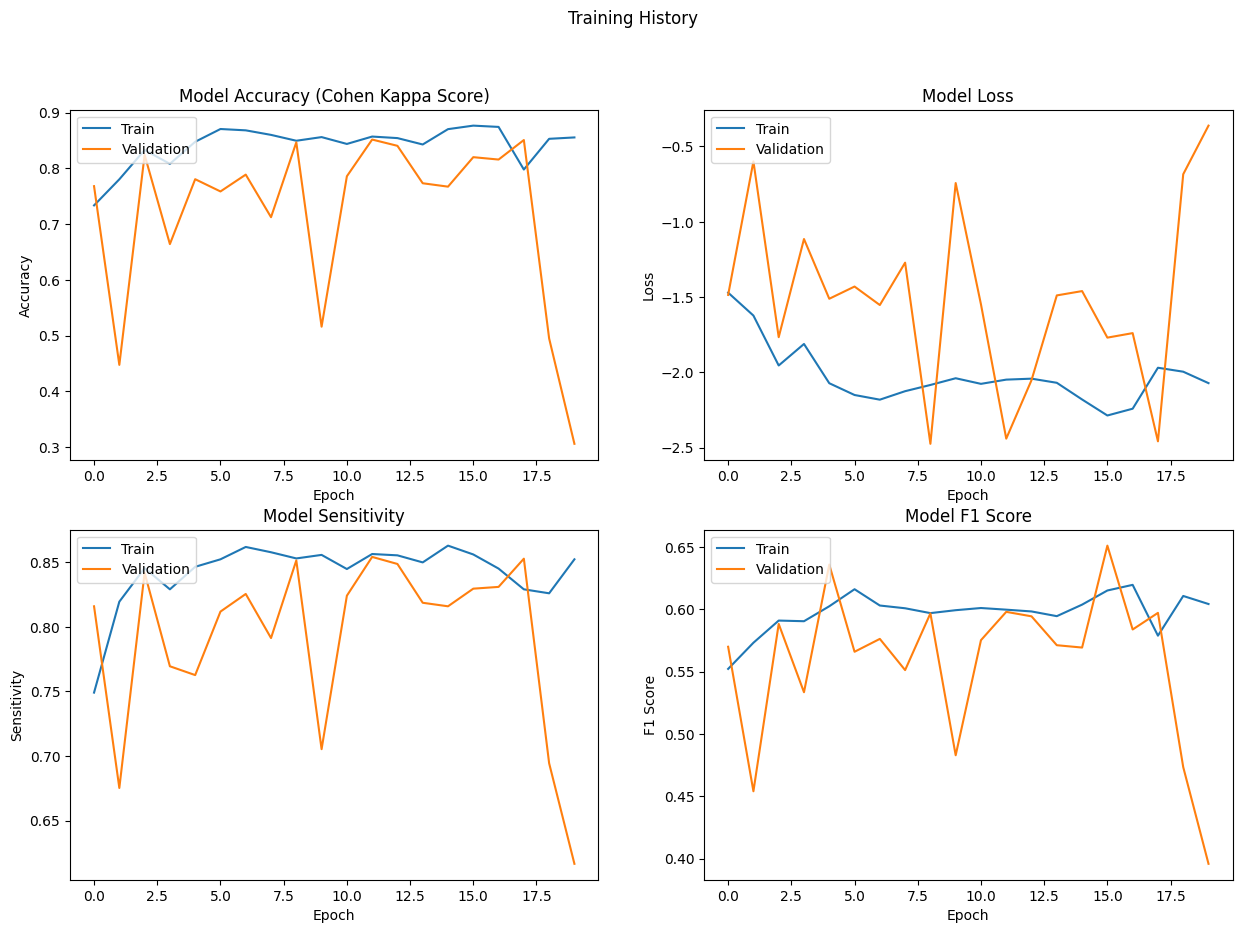

In [37]:
plot_training_history(vgg16_bs32_img128_allCLAHE4_history)

# Finetuning VGG16 using the best preprocessing techniques

In [ ]:
def train_unfreezed_model(
    model, model_name, batch_size, epochs=30, initial_epoch=0, 
    initial_value_threshold=None, additional_callbacks=[]):
    if not os.path.exists(os.path.join(outputs_dir, model_name)):
        os.makedirs(os.path.join(outputs_dir, model_name))

    model_history = model.fit(
        train_generator,
        steps_per_epoch=np.ceil(float(len(x_train)) / float(batch_size)),
        validation_data=val_generator,
        validation_steps=np.ceil(float(len(x_val)) / float(batch_size)),
        class_weight=get_class_weights(y_train),
        epochs=epochs,
        initial_epoch=initial_epoch,
        workers=1, 
        use_multiprocessing=False,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.TerminateOnNaN(),
            tf.keras.callbacks.CSVLogger(os.path.join(outputs_dir, model_name, f'{model_name}_trainableTrue_training.log'), separator=',', append=True),
            tf.keras.callbacks.ModelCheckpoint(os.path.join(outputs_dir, model_name, f'{model_name}_trainableTrue'), 
                                 monitor='val_loss', verbose=1, 
                                 save_best_only=True, mode='min', initial_value_threshold=initial_value_threshold),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='min', min_delta=0.0001),
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)
        ] + additional_callbacks
    )
    return model_history, model

In [18]:
train_generator = CustomImageGenerator(x_train, y_train, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, 
                                       train_dir=train_images_dir, is_train=True, augment=True,
                                       apply_clahe=True, clip_limit=4, tile_grid_size=(40, 40),
                                       all_clahe=True)

NameError: name 'BATCH_SIZE' is not defined

In [72]:
vgg16_bs32_img128_allCLAHE4_loaded2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

In [73]:
for layer in vgg16_bs32_img128_allCLAHE4_loaded2.layers:
    layer.trainable = True
vgg16_bs32_img128_allCLAHE4_loaded2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

In [74]:
print(f"Old learning rate: {tf.keras.backend.get_value(vgg16_bs32_img128_allCLAHE4_loaded2.optimizer.lr)}")
tf.keras.backend.set_value(vgg16_bs32_img128_allCLAHE4_loaded2.optimizer.lr, 1e-5)
print(f"New learning rate: {tf.keras.backend.get_value(vgg16_bs32_img128_allCLAHE4_loaded2.optimizer.lr)}")

Old learning rate: 0.0010000000474974513
New learning rate: 9.999999747378752e-06


In [ ]:
vgg16_bs32_img128_allCLAHE4_loaded2_history, vgg16_bs32_img128_allCLAHE4_loaded2 = train_unfreezed_model(
    vgg16_bs32_img128_allCLAHE4_loaded2, model_name='VGG16_32_128_ALLCLAHE_4_40_v3', batch_size=BATCH_SIZE)

Epoch 1/20
92/92 [==============================] - ETA: 0s - loss: -1.8595 - cohen_kappa: 0.8305 - sensitivity: 0.8433 - f1_score: 0.5917 - auc: 0.8859 - Multilabel_confusion_matrix: 732.2500 
Epoch 1: val_loss improved from inf to -2.51580, saving model to ./aptos_results2/VGG16_32_128_ALLCLAHE_4_40_v3/VGG16_32_128_ALLCLAHE_4_40_v3_trainableTrue


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_ALLCLAHE_4_40_v3/VGG16_32_128_ALLCLAHE_4_40_v3_trainableTrue/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_ALLCLAHE_4_40_v3/VGG16_32_128_ALLCLAHE_4_40_v3_trainableTrue/assets


92/92 [==============================] - 1197s 13s/step - loss: -1.8595 - cohen_kappa: 0.8305 - sensitivity: 0.8433 - f1_score: 0.5917 - auc: 0.8859 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.5158 - val_cohen_kappa: 0.8519 - val_sensitivity: 0.8540 - val_f1_score: 0.5983 - val_auc: 0.8964 - val_Multilabel_confusion_matrix: 183.2500
Epoch 2/20
92/92 [==============================] - ETA: 0s - loss: -1.9926 - cohen_kappa: 0.8466 - sensitivity: 0.8508 - f1_score: 0.5968 - auc: 0.8920 - Multilabel_confusion_matrix: 732.2500 
Epoch 2: val_loss improved from -2.51580 to -2.51948, saving model to ./aptos_results2/VGG16_32_128_ALLCLAHE_4_40_v3/VGG16_32_128_ALLCLAHE_4_40_v3_trainableTrue


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_ALLCLAHE_4_40_v3/VGG16_32_128_ALLCLAHE_4_40_v3_trainableTrue/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_32_128_ALLCLAHE_4_40_v3/VGG16_32_128_ALLCLAHE_4_40_v3_trainableTrue/assets


92/92 [==============================] - 1227s 13s/step - loss: -1.9926 - cohen_kappa: 0.8466 - sensitivity: 0.8508 - f1_score: 0.5968 - auc: 0.8920 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.5195 - val_cohen_kappa: 0.8575 - val_sensitivity: 0.8568 - val_f1_score: 0.6001 - val_auc: 0.8937 - val_Multilabel_confusion_matrix: 183.2500
Epoch 3/20
92/92 [==============================] - ETA: 0s - loss: -2.0606 - cohen_kappa: 0.8586 - sensitivity: 0.8569 - f1_score: 0.6006 - auc: 0.8949 - Multilabel_confusion_matrix: 732.2500 
Epoch 3: val_loss did not improve from -2.51948
92/92 [==============================] - 1212s 13s/step - loss: -2.0606 - cohen_kappa: 0.8586 - sensitivity: 0.8569 - f1_score: 0.6006 - auc: 0.8949 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.4831 - val_cohen_kappa: 0.8487 - val_sensitivity: 0.8527 - val_f1_score: 0.5971 - val_auc: 0.8942 - val_Multilabel_confusion_matrix: 183.2500
Epoch 4/20
92/92 [==============================] - ETA: 0s - loss

In [15]:
print(f"Old learning rate: {tf.keras.backend.get_value(vgg16_bs32_img128_allCLAHE4_loaded2.optimizer.lr)}")
tf.keras.backend.set_value(vgg16_bs32_img128_allCLAHE4_loaded2.optimizer.lr, 5e-5)
print(f"New learning rate: {tf.keras.backend.get_value(vgg16_bs32_img128_allCLAHE4_loaded2.optimizer.lr)}")

Old learning rate: 9.999999747378752e-06
New learning rate: 4.999999873689376e-05


In [20]:
vgg16_bs32_img128_allCLAHE4_loaded2_history, vgg16_bs32_img128_allCLAHE4_loaded2 = train_unfreezed_model(
    vgg16_bs32_img128_allCLAHE4_loaded2, model_name='VGG16_32_128_ALLCLAHE_4_40_v3', batch_size=BATCH_SIZE, initial_epoch=17, initial_value_threshold=-2.51948)

Epoch 18/20
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
92/92 [==============================] - ETA: 0s - loss: -0.2038 - cohen_kappa: 0.1082 - sensitivity: 0.4688 - f1_score: 0.2846 - auc: 0.6015 - Multilabel_confusion_matrix: 732.2500 
Epoch 18: val_loss did not improve from -2.51948
92/92 [==============================] - 1539s 17s/step - loss: -0.2038 - cohen_kappa: 0.1082 - sensitivity: 0.4688 - f1_score: 0.2846 - auc: 0.6015 - Multilabel_confusion_matrix: 732.2500 - val_loss: -0.6426 - val_cohen_kappa: 0.4733 - val_sensitivity: 0.6862 - val_f1_score: 0.4631 - val_auc: 0.7647 - val_Multilabel_confusion_matrix: 183.2500 - lr: 5.0000e-05
Epoch 19/20
92/92 [==============================] - ETA: 0s - loss: -1.1769 - cohen_kappa: 0.6029 - sensitivity: 0.7357 - f1_score: 0.5153 - auc: 0.8018 - Multilabel_confusion_matrix: 732.250

# InceptionV3 - CLAHE(4, 40) 3 channels, Batch Size 32, Image Size 128

In [47]:
model_name = 'InceptionV3_32_128_ALLCLAHE_4_40'

inceptionV3_img128_base = InceptionV3(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    classes=NUM_CLASSES
)

inceptionV3_bs32_img128_allCLAHE4 = build_model(
    inceptionV3_img128_base, 
    is_trainable=False, 
    image_size=IMAGE_SIZE, 
    num_classes=NUM_CLASSES, 
    model_name='InceptionV3'
)

87910968/87910968 [==============================] - 3s 0us/step
========================= MODEL SUMMARY =========================
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0      

In [ ]:
inceptionV3_bs32_img128_allCLAHE4 = compile_model(inceptionV3_bs32_img128_allCLAHE4, optimizer=Adam())

inceptionV3_bs32_img128_allCLAHE4_history, vgg16_bs32_img128_allCLAHE4 = train_freezed_pretrained_model(
    inceptionV3_bs32_img128_allCLAHE4, model_name, batch_size=BATCH_SIZE)

# ResNet50V2 - CLAHE(4, 40) 3 channels, Batch Size 32, Image Size 128

In [16]:
BATCH_SIZE = 32
IMAGE_SIZE = 128

train_generator = CustomImageGenerator(x_train, y_train, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, 
                                       train_dir=train_images_dir, is_train=True, augment=True,
                                       apply_clahe=True, clip_limit=4, tile_grid_size=(40, 40),
                                       all_clahe=True)

val_generator = CustomImageGenerator(x_val, y_val, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, 
                                     train_dir=train_images_dir, is_train=False,
                                     apply_clahe=True, clip_limit=4, tile_grid_size=(40, 40),
                                     all_clahe=True)

In [13]:
model_name = 'ResNet50V2_32_128_ALLCLAHE_4_40'

resnet50V2_img128_base = ResNet50V2(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    classes=NUM_CLASSES
)

resnet50V2_bs32_img128_allCLAHE4 = build_model(
    resnet50V2_img128_base, 
    is_trainable=False, 
    image_size=IMAGE_SIZE, 
    num_classes=NUM_CLASSES, 
    model_name='ResNet50V2'
)

========================= MODEL SUMMARY =========================
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [14]:
resnet50V2_bs32_img128_allCLAHE4 = compile_model(resnet50V2_bs32_img128_allCLAHE4, optimizer=Adam())

resnet50V2_bs32_img128_allCLAHE4_history, resnet50V2_bs32_img128_allCLAHE4 = train_freezed_pretrained_model(
    resnet50V2_bs32_img128_allCLAHE4, model_name, batch_size=BATCH_SIZE)

Epoch 1/20
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
92/92 [==============================] - ETA: 0s - loss: -1.4143 - cohen_kappa: 0.7498 - sensitivity: 0.7832 - f1_score: 0.5977 - auc: 0.8687 - Multilabel_confusion_matrix: 732.2500
Epoch 1: val_loss improved from inf to -0.59933, saving model to ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableFalse


INFO:tensorflow:Assets written to: ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableFalse/assets


INFO:tensorflow:Assets written to: ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableFalse/assets


92/92 [==============================] - 633s 7s/step - loss: -1.4143 - cohen_kappa: 0.7498 - sensitivity: 0.7832 - f1_score: 0.5977 - auc: 0.8687 - Multilabel_confusion_matrix: 732.2500 - val_loss: -0.5993 - val_cohen_kappa: 0.4500 - val_sensitivity: 0.6767 - val_f1_score: 0.4547 - val_auc: 0.7825 - val_Multilabel_confusion_matrix: 183.2500
Epoch 2/20
92/92 [==============================] - ETA: 0s - loss: -1.6994 - cohen_kappa: 0.8062 - sensitivity: 0.8324 - f1_score: 0.5828 - auc: 0.8787 - Multilabel_confusion_matrix: 732.2500
Epoch 2: val_loss improved from -0.59933 to -1.10285, saving model to ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableFalse


INFO:tensorflow:Assets written to: ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableFalse/assets


INFO:tensorflow:Assets written to: ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableFalse/assets


92/92 [==============================] - 612s 7s/step - loss: -1.6994 - cohen_kappa: 0.8062 - sensitivity: 0.8324 - f1_score: 0.5828 - auc: 0.8787 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.1028 - val_cohen_kappa: 0.6626 - val_sensitivity: 0.7681 - val_f1_score: 0.5345 - val_auc: 0.8508 - val_Multilabel_confusion_matrix: 183.2500
Epoch 3/20
92/92 [==============================] - ETA: 0s - loss: -2.0081 - cohen_kappa: 0.8332 - sensitivity: 0.8453 - f1_score: 0.5915 - auc: 0.8885 - Multilabel_confusion_matrix: 732.2500
Epoch 3: val_loss did not improve from -1.10285
92/92 [==============================] - 568s 6s/step - loss: -2.0081 - cohen_kappa: 0.8332 - sensitivity: 0.8453 - f1_score: 0.5915 - auc: 0.8885 - Multilabel_confusion_matrix: 732.2500 - val_loss: -0.4282 - val_cohen_kappa: 0.3520 - val_sensitivity: 0.6357 - val_f1_score: 0.4153 - val_auc: 0.7347 - val_Multilabel_confusion_matrix: 183.2500
Epoch 4/20
92/92 [==============================] - ETA: 0s - loss: -1.

INFO:tensorflow:Assets written to: ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableFalse/assets


INFO:tensorflow:Assets written to: ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableFalse/assets


92/92 [==============================] - 607s 7s/step - loss: -1.7470 - cohen_kappa: 0.8065 - sensitivity: 0.8327 - f1_score: 0.5826 - auc: 0.8807 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.9422 - val_cohen_kappa: 0.8537 - val_sensitivity: 0.8554 - val_f1_score: 0.5983 - val_auc: 0.8964 - val_Multilabel_confusion_matrix: 183.2500
Epoch 5/20
92/92 [==============================] - ETA: 0s - loss: -1.8678 - cohen_kappa: 0.8193 - sensitivity: 0.8351 - f1_score: 0.5985 - auc: 0.8804 - Multilabel_confusion_matrix: 732.2500
Epoch 5: val_loss did not improve from -1.94218
92/92 [==============================] - 564s 6s/step - loss: -1.8678 - cohen_kappa: 0.8193 - sensitivity: 0.8351 - f1_score: 0.5985 - auc: 0.8804 - Multilabel_confusion_matrix: 732.2500 - val_loss: -0.8133 - val_cohen_kappa: 0.5536 - val_sensitivity: 0.7026 - val_f1_score: 0.5399 - val_auc: 0.7915 - val_Multilabel_confusion_matrix: 183.2500
Epoch 6/20
92/92 [==============================] - ETA: 0s - loss: -1.

In [16]:
for layer in resnet50V2_bs32_img128_allCLAHE4.layers:
    layer.trainable = True
resnet50V2_bs32_img128_allCLAHE4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [17]:
print(f"Old learning rate: {tf.keras.backend.get_value(resnet50V2_bs32_img128_allCLAHE4.optimizer.lr)}")
tf.keras.backend.set_value(resnet50V2_bs32_img128_allCLAHE4.optimizer.lr, 1e-5)
print(f"New learning rate: {tf.keras.backend.get_value(resnet50V2_bs32_img128_allCLAHE4.optimizer.lr)}")

Old learning rate: 0.0010000000474974513
New learning rate: 9.999999747378752e-06


In [19]:
resnet50V2_bs32_img128_allCLAHE4_history, resnet50V2_bs32_img128_allCLAHE4 = train_unfreezed_model(
    resnet50V2_bs32_img128_allCLAHE4, model_name, batch_size=BATCH_SIZE)

Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: -2.0360 - cohen_kappa: 0.8522 - sensitivity: 0.8542 - f1_score: 0.5978 - auc: 0.8922 - Multilabel_confusion_matrix: 732.2500
Epoch 1: val_loss improved from inf to -1.41087, saving model to ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableTrue


INFO:tensorflow:Assets written to: ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableTrue/assets


INFO:tensorflow:Assets written to: ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableTrue/assets


92/92 [==============================] - 809s 9s/step - loss: -2.0360 - cohen_kappa: 0.8522 - sensitivity: 0.8542 - f1_score: 0.5978 - auc: 0.8922 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.4109 - val_cohen_kappa: 0.7552 - val_sensitivity: 0.8104 - val_f1_score: 0.5645 - val_auc: 0.8601 - val_Multilabel_confusion_matrix: 183.2500 - lr: 1.0000e-05
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: -2.0515 - cohen_kappa: 0.8558 - sensitivity: 0.8559 - f1_score: 0.5990 - auc: 0.8922 - Multilabel_confusion_matrix: 732.2500
Epoch 2: val_loss did not improve from -1.41087
92/92 [==============================] - 771s 8s/step - loss: -2.0515 - cohen_kappa: 0.8558 - sensitivity: 0.8559 - f1_score: 0.5990 - auc: 0.8922 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.4032 - val_cohen_kappa: 0.7522 - val_sensitivity: 0.8090 - val_f1_score: 0.5634 - val_auc: 0.8610 - val_Multilabel_confusion_matrix: 183.2500 - lr: 1.0000e-05
Epoch 3/30
92/92 [===================

INFO:tensorflow:Assets written to: ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableTrue/assets


INFO:tensorflow:Assets written to: ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableTrue/assets


92/92 [==============================] - 800s 9s/step - loss: -2.0659 - cohen_kappa: 0.8565 - sensitivity: 0.8563 - f1_score: 0.5992 - auc: 0.8925 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.4113 - val_cohen_kappa: 0.7552 - val_sensitivity: 0.8104 - val_f1_score: 0.5645 - val_auc: 0.8614 - val_Multilabel_confusion_matrix: 183.2500 - lr: 5.0000e-06
Epoch 7/30
92/92 [==============================] - ETA: 0s - loss: -2.0460 - cohen_kappa: 0.8565 - sensitivity: 0.8563 - f1_score: 0.5992 - auc: 0.8928 - Multilabel_confusion_matrix: 732.2500
Epoch 7: val_loss did not improve from -1.41135
92/92 [==============================] - 773s 8s/step - loss: -2.0460 - cohen_kappa: 0.8565 - sensitivity: 0.8563 - f1_score: 0.5992 - auc: 0.8928 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.4030 - val_cohen_kappa: 0.7522 - val_sensitivity: 0.8090 - val_f1_score: 0.5634 - val_auc: 0.8613 - val_Multilabel_confusion_matrix: 183.2500 - lr: 5.0000e-06
Epoch 8/30
92/92 [===================

INFO:tensorflow:Assets written to: ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableTrue/assets


INFO:tensorflow:Assets written to: ./aptos_results2/ResNet50V2_32_128_ALLCLAHE_4_40/ResNet50V2_32_128_ALLCLAHE_4_40_trainableTrue/assets


92/92 [==============================] - 797s 9s/step - loss: -2.0848 - cohen_kappa: 0.8580 - sensitivity: 0.8569 - f1_score: 0.5997 - auc: 0.8926 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.4207 - val_cohen_kappa: 0.7582 - val_sensitivity: 0.8117 - val_f1_score: 0.5655 - val_auc: 0.8622 - val_Multilabel_confusion_matrix: 183.2500 - lr: 2.5000e-06
Epoch 12/30
92/92 [==============================] - ETA: 0s - loss: -2.0960 - cohen_kappa: 0.8580 - sensitivity: 0.8569 - f1_score: 0.5997 - auc: 0.8928 - Multilabel_confusion_matrix: 732.2500
Epoch 12: val_loss did not improve from -1.42067
92/92 [==============================] - 767s 8s/step - loss: -2.0960 - cohen_kappa: 0.8580 - sensitivity: 0.8569 - f1_score: 0.5997 - auc: 0.8928 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.4167 - val_cohen_kappa: 0.7552 - val_sensitivity: 0.8104 - val_f1_score: 0.5645 - val_auc: 0.8623 - val_Multilabel_confusion_matrix: 183.2500 - lr: 2.5000e-06
Epoch 13/30
92/92 [================

# EfficientNetV2S

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 128

train_generator = CustomImageGenerator(x_train, y_train, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, 
                                       train_dir=train_images_dir, is_train=True, augment=True,
                                       apply_clahe=True, clip_limit=4, tile_grid_size=(40, 40),
                                       all_clahe=True)

val_generator = CustomImageGenerator(x_val, y_val, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, 
                                     train_dir=train_images_dir, is_train=False,
                                     apply_clahe=True, clip_limit=4, tile_grid_size=(40, 40),
                                     all_clahe=True)

In [ ]:
model_name = 'EfficientNetV2S_32_128_ALLCLAHE4'

efficientnetV2S_img128_base = EfficientNetV2S(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    classes=NUM_CLASSES,
    include_preprocessing=True
)

efficientnetV2S_bs32_img128_allCLAHE4 = build_model(
    efficientnetV2S_img128_base, 
    is_trainable=False, 
    image_size=IMAGE_SIZE, 
    num_classes=NUM_CLASSES, 
    model_name='EfficientNetV2S'
)

82420632/82420632 [==============================] - 1s 0us/step
========================= MODEL SUMMARY =========================
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, 4, 4, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 128)               32896  

In [ ]:
efficientnetV2S_bs32_img128_allCLAHE4 = compile_model(efficientnetV2S_bs32_img128_allCLAHE4, optimizer=Adam())

efficientnetV2S_bs32_img128_allCLAHE4_history, efficientnetV2S_bs32_img128_allCLAHE4 = train_freezed_pretrained_model(
    efficientnetV2S_bs32_img128_allCLAHE4, model_name, batch_size=BATCH_SIZE, initial_value_threshold=-1.23958)

Epoch 1/20


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


92/92 [==============================] - ETA: 0s - loss: -1.6284 - cohen_kappa: 0.7991 - sensitivity: 0.8027 - f1_score: 0.5929 - auc: 0.9012 - Multilabel_confusion_matrix: 732.2500 
Epoch 1: val_loss improved from -1.23958 to -1.64678, saving model to /content/drive/MyDrive/Colab Notebooks/aptos_results2/EfficientNetV2S_32_128_ALLCLAHE4/EfficientNetV2S_32_128_ALLCLAHE4_trainableFalse


92/92 [==============================] - 2056s 22s/step - loss: -1.6284 - cohen_kappa: 0.7991 - sensitivity: 0.8027 - f1_score: 0.5929 - auc: 0.9012 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.6468 - val_cohen_kappa: 0.8039 - val_sensitivity: 0.8240 - val_f1_score: 0.5820 - val_auc: 0.9074 - val_Multilabel_confusion_matrix: 183.2500
Epoch 2/20
92/92 [==============================] - ETA: 0s - loss: -2.0670 - cohen_kappa: 0.8594 - sensitivity: 0.8569 - f1_score: 0.6004 - auc: 0.9017 - Multilabel_confusion_matrix: 732.2500 
Epoch 2: val_loss did not improve from -1.64678
92/92 [==============================] - 1319s 14s/step - loss: -2.0670 - cohen_kappa: 0.8594 - sensitivity: 0.8569 - f1_score: 0.6004 - auc: 0.9017 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.2429 - val_cohen_kappa: 0.7068 - val_sensitivity: 0.7885 - val_f1_score: 0.5487 - val_auc: 0.8699 - val_Multilabel_confusion_matrix: 183.2500
Epoch 3/20
92/92 [==============================] - ETA: 0s - loss

92/92 [==============================] - 1587s 17s/step - loss: -1.3912 - cohen_kappa: 0.6273 - sensitivity: 0.7433 - f1_score: 0.5232 - auc: 0.8158 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.6935 - val_cohen_kappa: 0.7936 - val_sensitivity: 0.8267 - val_f1_score: 0.5790 - val_auc: 0.8839 - val_Multilabel_confusion_matrix: 183.2500
Epoch 10/20
92/92 [==============================] - ETA: 0s - loss: -2.1086 - cohen_kappa: 0.8497 - sensitivity: 0.8532 - f1_score: 0.5969 - auc: 0.8928 - Multilabel_confusion_matrix: 732.2500 
Epoch 10: val_loss did not improve from -1.69352
92/92 [==============================] - 1323s 14s/step - loss: -2.1086 - cohen_kappa: 0.8497 - sensitivity: 0.8532 - f1_score: 0.5969 - auc: 0.8928 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.2765 - val_cohen_kappa: 0.7128 - val_sensitivity: 0.7913 - val_f1_score: 0.5513 - val_auc: 0.8536 - val_Multilabel_confusion_matrix: 183.2500
Epoch 11/20
92/92 [==============================] - ETA: 0s - l

92/92 [==============================] - 1921s 21s/step - loss: -1.9652 - cohen_kappa: 0.8340 - sensitivity: 0.8457 - f1_score: 0.5919 - auc: 0.8853 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.7174 - val_cohen_kappa: 0.7839 - val_sensitivity: 0.8213 - val_f1_score: 0.5761 - val_auc: 0.8701 - val_Multilabel_confusion_matrix: 183.2500
Epoch 17/20
92/92 [==============================] - ETA: 0s - loss: -2.1225 - cohen_kappa: 0.8423 - sensitivity: 0.8498 - f1_score: 0.5944 - auc: 0.8894 - Multilabel_confusion_matrix: 732.2500 
Epoch 17: val_loss improved from -1.71743 to -1.89502, saving model to /content/drive/MyDrive/Colab Notebooks/aptos_results2/EfficientNetV2S_32_128_ALLCLAHE4/EfficientNetV2S_32_128_ALLCLAHE4_trainableFalse


92/92 [==============================] - 1636s 18s/step - loss: -2.1225 - cohen_kappa: 0.8423 - sensitivity: 0.8498 - f1_score: 0.5944 - auc: 0.8894 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.8950 - val_cohen_kappa: 0.8285 - val_sensitivity: 0.8431 - val_f1_score: 0.5906 - val_auc: 0.8859 - val_Multilabel_confusion_matrix: 183.2500
Epoch 18/20
92/92 [==============================] - ETA: 0s - loss: -2.1887 - cohen_kappa: 0.8486 - sensitivity: 0.8522 - f1_score: 0.5974 - auc: 0.8907 - Multilabel_confusion_matrix: 732.2500 
Epoch 18: val_loss did not improve from -1.89502
92/92 [==============================] - 1350s 15s/step - loss: -2.1887 - cohen_kappa: 0.8486 - sensitivity: 0.8522 - f1_score: 0.5974 - auc: 0.8907 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.4656 - val_cohen_kappa: 0.7584 - val_sensitivity: 0.8117 - val_f1_score: 0.5668 - val_auc: 0.8662 - val_Multilabel_confusion_matrix: 183.2500
Epoch 19/20
92/92 [==============================] - ETA: 0s - l

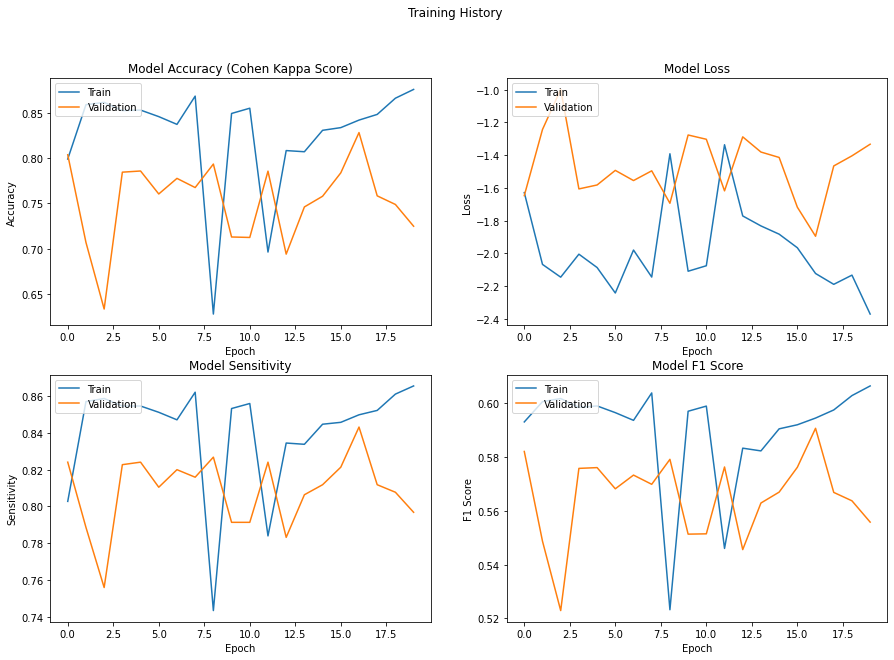

In [ ]:
plot_training_history(efficientnetV2S_bs32_img128_allCLAHE4_history)

In [ ]:
for layer in efficientnetV2S_bs32_img128_allCLAHE4.layers:
    layer.trainable = True
efficientnetV2S_bs32_img128_allCLAHE4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, 4, 4, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 predictions (Dense)         (None, 3)                 387   

In [ ]:
print(f"Old learning rate: {tf.keras.backend.get_value(efficientnetV2S_bs32_img128_allCLAHE4.optimizer.lr)}")
tf.keras.backend.set_value(efficientnetV2S_bs32_img128_allCLAHE4.optimizer.lr, 2e-5)
print(f"New learning rate: {tf.keras.backend.get_value(efficientnetV2S_bs32_img128_allCLAHE4.optimizer.lr)}")

Old learning rate: 0.0010000000474974513
New learning rate: 1.9999999494757503e-05


In [ ]:
efficientnetV2S_bs32_img128_allCLAHE4_finetuned_history, efficientnetV2S_bs32_img128_allCLAHE4 = train_unfreezed_model(
    efficientnetV2S_bs32_img128_allCLAHE4, model_name=model_name, batch_size=BATCH_SIZE, initial_value_threshold=-1.91815)

Epoch 1/30


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


92/92 [==============================] - ETA: 0s - loss: -2.0781 - cohen_kappa: 0.8655 - sensitivity: 0.8604 - f1_score: 0.6026 - auc: 0.8968 - Multilabel_confusion_matrix: 732.2500 
Epoch 1: val_loss did not improve from -1.91815
92/92 [==============================] - 2962s 32s/step - loss: -2.0781 - cohen_kappa: 0.8655 - sensitivity: 0.8604 - f1_score: 0.6026 - auc: 0.8968 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.8909 - val_cohen_kappa: 0.8368 - val_sensitivity: 0.8472 - val_f1_score: 0.5932 - val_auc: 0.8885 - val_Multilabel_confusion_matrix: 183.2500 - lr: 2.0000e-05
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: -2.2415 - cohen_kappa: 0.8676 - sensitivity: 0.8614 - f1_score: 0.6032 - auc: 0.8968 - Multilabel_confusion_matrix: 732.2500 
Epoch 2: val_loss did not improve from -1.91815
92/92 [==============================] - 1279s 14s/step - loss: -2.2415 - cohen_kappa: 0.8676 - sensitivity: 0.8614 - f1_score: 0.6032 - auc: 0.8968 - Multilabel_co

# Stacked Ensemble Model

In [46]:
# Function to load features and labels for ensemble model
def load_features_and_labels(image_filenames, labels, image_size, train_dir, image_file_ext='.png', is_train=False, augment=True,
                 apply_clahe=True, clip_limit=4, tile_grid_size=(40, 40), all_clahe=True):
    if (is_train):
        image_filenames, labels = shuffle(image_filenames, labels)
    
    dr_preprocessor = DRImagePreprocessor(image_size, apply_clahe, clip_limit=clip_limit, tile_grid_size=tile_grid_size, all_clahe=all_clahe)
    
    images = []
    for img_name in tqdm(image_filenames):
        image_path = os.path.join(train_dir, img_name + image_file_ext)

        # Apply eye image specific preprocessing
        img = dr_preprocessor.preprocess_image(image_path)

        if(augment):
            img = ImageDataGenerator().apply_transform(img, 
                                                       transform_parameters={
                                                           'theta': 180, 'tx': 0.2, 'ty': 0.2, 
                                                           'shear': 20, 'flip_horizontal': True
                                                        })
        images.append(img)
    images = np.array(images, np.float32)
    y = np.array(labels, np.float32)
    
    return images, y

In [18]:
def load_models(model_names):
    models = []
    for model_name in model_names:
        model = tf.keras.models.load_model(os.path.join(outputs_dir, model_name, f'{model_name}_trainableTrue'), custom_objects={
            'WeightedKappaLoss': tfa.losses.WeightedKappaLoss,
            'CohenKappa': tfa.metrics.CohenKappa,
            'F1Score': tfa.metrics.F1Score,
            'MultiLabelConfusionMatrix': tfa.metrics.MultiLabelConfusionMatrix
        })
        models.append(model)
        print('loaded:', model_name)
    return models

In [19]:
def build_ensemble_model(models):
    for model in models:
        for layer in model.layers:
            layer.trainable = False

    ensemble_inputs = [model.input for model in models]
    ensemble_outputs = [model.output for model in models]
    merged = tf.keras.layers.concatenate(ensemble_outputs)
    merged = tf.keras.layers.Dense(16, activation='relu')(merged)
    final_output = tf.keras.layers.Dense(3, activation='softmax')(merged)
    ensemble_model = tf.keras.models.Model(inputs=ensemble_inputs, outputs=final_output)
    
    # Print summary
    print('========================= MODEL SUMMARY =========================')
    print(ensemble_model.summary())
    
    return ensemble_model

In [25]:
def train_ensemble_model(
    model, model_name, batch_size, epochs=20, initial_epoch=0, 
    initial_value_threshold=None, additional_callbacks=[]):
    if not os.path.exists(os.path.join(outputs_dir, model_name)):
        os.makedirs(os.path.join(outputs_dir, model_name))

    model_history = model.fit(
        X_train_ensemble, Y_train,
        steps_per_epoch=np.ceil(float(len(x_train)) / float(batch_size)),
        validation_data=(X_val_ensemble, Y_val),
        validation_steps=np.ceil(float(len(x_val)) / float(batch_size)),
        class_weight=get_class_weights(y_train),
        batch_size=batch_size,
        epochs=epochs,
        initial_epoch=initial_epoch,
        workers=1, 
        use_multiprocessing=False,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.TerminateOnNaN(),
            tf.keras.callbacks.CSVLogger(os.path.join(outputs_dir, model_name, f'{model_name}_training.log'), separator=',', append=True),
            tf.keras.callbacks.ModelCheckpoint(os.path.join(outputs_dir, model_name, f'_32_128_ALLCLAHE4'), 
                                 monitor='val_loss', verbose=1, 
                                 save_best_only=True, mode='min', initial_value_threshold=initial_value_threshold),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='min', min_delta=0.0001),
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)
        ] + additional_callbacks
    )
    return model_history, model

In [29]:
models = load_models(['VGG16_32_128_ALLCLAHE_4_40_v3', 'EfficientNetV2S_32_128_ALLCLAHE_4_40', 'ResNet50V2_32_128_ALLCLAHE_4_40'])

loaded: VGG16_32_128_ALLCLAHE_4_40_v3
loaded: EfficientNetV2S_32_128_ALLCLAHE_4_40
loaded: ResNet50V2_32_128_ALLCLAHE_4_40


In [68]:
def make_layer_names_unique(model, model_name):
    model.layers[0]._name = f'{model_name}_{model.layers[0].name}'
    for i in range(2, 8):
        model.layers[i]._name = f'{model_name}_{model.layers[i].name}'
    return model

In [58]:
models[0] = make_layer_names_unique(models[0], 'vgg16')
models[1] = make_layer_names_unique(models[1], 'efficientnetV2S')
models[2] = make_layer_names_unique(models[2], 'resnet50V2')

In [70]:
ensemble_model = build_ensemble_model(models)

========================= MODEL SUMMARY =========================
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vgg16_input_6 (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50V2_input_2 (InputLayer  [(None, 128, 128, 3  0          []                               
 )                              )]                                                                
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None, 128, 128, 3)  0          ['vgg16_input_6[0][0]']          
 icingOpLambda)           

In [ ]:
X_train, Y_train = load_features_and_labels(x_train, y_train, image_size=IMAGE_SIZE, 
                                           train_dir=train_images_dir, is_train=True, augment=True,
                                           apply_clahe=True, clip_limit=4, tile_grid_size=(40, 40),
                                           all_clahe=True)
X_val, Y_val = load_features_and_labels(x_val, y_val, image_size=IMAGE_SIZE, 
                                         train_dir=train_images_dir, is_train=False, augment=False,
                                         apply_clahe=True, clip_limit=4, tile_grid_size=(40, 40),
                                         all_clahe=True)

In [24]:
X_train_ensemble = [X_train for _ in range(len(ensemble_model.input))]
X_val_ensemble = [X_val for _ in range(len(ensemble_model.input))]

In [72]:
ensemble_model = compile_model(ensemble_model, optimizer=Adam())

In [ ]:
ensemble_model_history, ensemble_model = train_ensemble_model(
    ensemble_model, 'VGG16_EfficientNetV2S_ResNet50V2', batch_size=BATCH_SIZE)

Epoch 1/20
92/92 [==============================] - ETA: 0s - loss: -0.1715 - cohen_kappa: 0.3765 - sensitivity: 0.2946 - f1_score: 0.2629 - auc: 0.5212 - Multilabel_confusion_matrix: 732.2500
Epoch 1: val_loss improved from inf to -0.43883, saving model to ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


92/92 [==============================] - 681s 7s/step - loss: -0.1715 - cohen_kappa: 0.3765 - sensitivity: 0.2946 - f1_score: 0.2629 - auc: 0.5212 - Multilabel_confusion_matrix: 732.2500 - val_loss: -0.4388 - val_cohen_kappa: 0.5597 - val_sensitivity: 0.4011 - val_f1_score: 0.3138 - val_auc: 0.7217 - val_Multilabel_confusion_matrix: 183.2500
Epoch 2/20
92/92 [==============================] - ETA: 0s - loss: -0.7392 - cohen_kappa: 0.5720 - sensitivity: 0.3960 - f1_score: 0.3201 - auc: 0.7482 - Multilabel_confusion_matrix: 732.2500
Epoch 2: val_loss improved from -0.43883 to -1.00797, saving model to ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


92/92 [==============================] - 645s 7s/step - loss: -0.7392 - cohen_kappa: 0.5720 - sensitivity: 0.3960 - f1_score: 0.3201 - auc: 0.7482 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.0080 - val_cohen_kappa: 0.8835 - val_sensitivity: 0.3820 - val_f1_score: 0.6482 - val_auc: 0.8833 - val_Multilabel_confusion_matrix: 183.2500
Epoch 3/20
92/92 [==============================] - ETA: 0s - loss: -1.5212 - cohen_kappa: 0.8826 - sensitivity: 0.8542 - f1_score: 0.6079 - auc: 0.8672 - Multilabel_confusion_matrix: 732.2500
Epoch 3: val_loss improved from -1.00797 to -1.79044, saving model to ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


92/92 [==============================] - 648s 7s/step - loss: -1.5212 - cohen_kappa: 0.8826 - sensitivity: 0.8542 - f1_score: 0.6079 - auc: 0.8672 - Multilabel_confusion_matrix: 732.2500 - val_loss: -1.7904 - val_cohen_kappa: 0.8800 - val_sensitivity: 0.8677 - val_f1_score: 0.6073 - val_auc: 0.9074 - val_Multilabel_confusion_matrix: 183.2500
Epoch 4/20
92/92 [==============================] - ETA: 0s - loss: -2.0584 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.8846 - Multilabel_confusion_matrix: 732.2500
Epoch 4: val_loss improved from -1.79044 to -2.04652, saving model to ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


92/92 [==============================] - 646s 7s/step - loss: -2.0584 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.8846 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.0465 - val_cohen_kappa: 0.8800 - val_sensitivity: 0.8677 - val_f1_score: 0.6073 - val_auc: 0.9155 - val_Multilabel_confusion_matrix: 183.2500
Epoch 5/20


In [ ]:
ensemble_model_history, ensemble_model = train_ensemble_model(
    ensemble_model, 'VGG16_EfficientNetV2S_ResNet50V2', batch_size=BATCH_SIZE, initial_epoch=4, initial_value_threshold=-2.04652)

Epoch 5/20
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
92/92 [==============================] - ETA: 0s - loss: -2.1906 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.8969 - Multilabel_confusion_matrix: 732.2500
Epoch 5: val_loss improved from -2.04652 to -2.09700, saving model to ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


92/92 [==============================] - 678s 7s/step - loss: -2.1906 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.8969 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.0970 - val_cohen_kappa: 0.8800 - val_sensitivity: 0.8677 - val_f1_score: 0.6073 - val_auc: 0.9248 - val_Multilabel_confusion_matrix: 183.2500
Epoch 6/20
92/92 [==============================] - ETA: 0s - loss: -2.2098 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9070 - Multilabel_confusion_matrix: 732.2500
Epoch 6: val_loss improved from -2.09700 to -2.15432, saving model to ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


92/92 [==============================] - 643s 7s/step - loss: -2.2098 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9070 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.1543 - val_cohen_kappa: 0.8800 - val_sensitivity: 0.8677 - val_f1_score: 0.6073 - val_auc: 0.9202 - val_Multilabel_confusion_matrix: 183.2500
Epoch 7/20
92/92 [==============================] - ETA: 0s - loss: -2.2269 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9066 - Multilabel_confusion_matrix: 732.2500
Epoch 7: val_loss improved from -2.15432 to -2.20004, saving model to ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


92/92 [==============================] - 647s 7s/step - loss: -2.2269 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9066 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.2000 - val_cohen_kappa: 0.8800 - val_sensitivity: 0.8677 - val_f1_score: 0.6073 - val_auc: 0.9192 - val_Multilabel_confusion_matrix: 183.2500
Epoch 8/20
92/92 [==============================] - ETA: 0s - loss: -2.2719 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9065 - Multilabel_confusion_matrix: 732.2500
Epoch 8: val_loss improved from -2.20004 to -2.23343, saving model to ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4


In [23]:
ensemble_model_history, ensemble_model = train_ensemble_model(
    ensemble_model, 'VGG16_EfficientNetV2S_ResNet50V2', batch_size=BATCH_SIZE, initial_epoch=7, initial_value_threshold=-2.23343)

Epoch 8/20
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
92/92 [==============================] - ETA: 0s - loss: -2.2514 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9039 - Multilabel_confusion_matrix: 732.2500
Epoch 8: val_loss improved from -2.23343 to -2.40494, saving model to ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


92/92 [==============================] - 679s 7s/step - loss: -2.2514 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9039 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.4049 - val_cohen_kappa: 0.8800 - val_sensitivity: 0.8677 - val_f1_score: 0.6073 - val_auc: 0.9008 - val_Multilabel_confusion_matrix: 183.2500
Epoch 9/20
92/92 [==============================] - ETA: 0s - loss: -2.3554 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9020 - Multilabel_confusion_matrix: 732.2500
Epoch 9: val_loss improved from -2.40494 to -2.41883, saving model to ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


92/92 [==============================] - 650s 7s/step - loss: -2.3554 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9020 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.4188 - val_cohen_kappa: 0.8800 - val_sensitivity: 0.8677 - val_f1_score: 0.6073 - val_auc: 0.9007 - val_Multilabel_confusion_matrix: 183.2500
Epoch 10/20
92/92 [==============================] - ETA: 0s - loss: -2.2376 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9013 - Multilabel_confusion_matrix: 732.2500
Epoch 10: val_loss did not improve from -2.41883
92/92 [==============================] - 488s 5s/step - loss: -2.2376 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9013 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.4122 - val_cohen_kappa: 0.8800 - val_sensitivity: 0.8677 - val_f1_score: 0.6073 - val_auc: 0.9008 - val_Multilabel_confusion_matrix: 183.2500
Epoch 11/20
92/92 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


92/92 [==============================] - 655s 7s/step - loss: -2.2777 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9025 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.4233 - val_cohen_kappa: 0.8800 - val_sensitivity: 0.8677 - val_f1_score: 0.6073 - val_auc: 0.9008 - val_Multilabel_confusion_matrix: 183.2500
Epoch 14/20
92/92 [==============================] - ETA: 0s - loss: -2.2690 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9013 - Multilabel_confusion_matrix: 732.2500
Epoch 14: val_loss improved from -2.42335 to -2.42692, saving model to ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


92/92 [==============================] - 649s 7s/step - loss: -2.2690 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9013 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.4269 - val_cohen_kappa: 0.8800 - val_sensitivity: 0.8677 - val_f1_score: 0.6073 - val_auc: 0.9008 - val_Multilabel_confusion_matrix: 183.2500
Epoch 15/20
92/92 [==============================] - ETA: 0s - loss: -2.2932 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9016 - Multilabel_confusion_matrix: 732.2500
Epoch 15: val_loss improved from -2.42692 to -2.47490, saving model to ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


INFO:tensorflow:Assets written to: ./aptos_results2/VGG16_EfficientNetV2S_ResNet50V2/_32_128_ALLCLAHE4/assets


92/92 [==============================] - 647s 7s/step - loss: -2.2932 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9016 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.4749 - val_cohen_kappa: 0.8800 - val_sensitivity: 0.8677 - val_f1_score: 0.6073 - val_auc: 0.9009 - val_Multilabel_confusion_matrix: 183.2500
Epoch 16/20
92/92 [==============================] - ETA: 0s - loss: -2.2651 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9013 - Multilabel_confusion_matrix: 732.2500
Epoch 16: val_loss did not improve from -2.47490
92/92 [==============================] - 497s 5s/step - loss: -2.2651 - cohen_kappa: 0.8820 - sensitivity: 0.8682 - f1_score: 0.6080 - auc: 0.9013 - Multilabel_confusion_matrix: 732.2500 - val_loss: -2.4649 - val_cohen_kappa: 0.8800 - val_sensitivity: 0.8677 - val_f1_score: 0.6073 - val_auc: 0.9009 - val_Multilabel_confusion_matrix: 183.2500
Epoch 17/20
92/92 [==============================] - ETA: 0s - loss: 

# Evaluation

In [50]:
def load_model():
    model = tf.keras.models.load_model(os.path.join(outputs_dir, 'VGG16_EfficientNetV2S_ResNet50V2', '_32_128_ALLCLAHE4'), custom_objects={
            'WeightedKappaLoss': tfa.losses.WeightedKappaLoss,
            'CohenKappa': tfa.metrics.CohenKappa,
            'F1Score': tfa.metrics.F1Score,
            'MultiLabelConfusionMatrix': tfa.metrics.MultiLabelConfusionMatrix
    })
    
    return model

In [ ]:
ensemble_model = load_model()

In [ ]:
X_test, Y_test = load_features_and_labels(x_test, y_test, image_size=IMAGE_SIZE, 
                                         train_dir=train_images_dir, 
                                         is_train=False, augment=False, image_file_ext='.png',
                                         apply_clahe=True, clip_limit=4, tile_grid_size=(40, 40),
                                         all_clahe=True)

100%|██████████| 367/367 [01:09<00:00,  5.26it/s]


In [174]:
def evaluate_ensemble_model(ensemble_model, X_test, Y_test):
    X_test_ensemble = [X_test for _ in range(len(ensemble_model.input))]

    results = ensemble_model.evaluate(X_test_ensemble, Y_test, return_dict=True, verbose=1)
    return results

In [135]:
evaluation_results = evaluate_ensemble_model(ensemble_model, X_test, Y_test)

12/12 [==============================] - 49s 4s/step - loss: -2.1171 - cohen_kappa: 0.8773 - sensitivity: 0.8665 - f1_score: 0.6064 - auc: 0.8999 - Multilabel_confusion_matrix: 91.7500


In [168]:
def print_evaluation_summary(results):
    qwk = round(results['cohen_kappa'] * 100)
    recall = round(results['sensitivity'] * 100)
    f1_score = round(results['f1_score'] * 100)
    auc = round(results['auc'] * 100)

    print('Results on Test Set (converted to percentages):')
    print(f'QWK Score: {qwk}%')
    print(f'Sensitivity: {recall}%')
    print(f'F1 Score: {f1_score}%')
    print(f'AUC-ROC Score: {auc}%')

In [ ]:
print_evaluation_summary(evaluation_results)

Results on Test Set (converted to percentages):
QWK Score: 88%
Sensitivity: 87%
F1 Score: 61%
AUC-ROC Score: 90%


# Model Deployment

In [194]:
def preprocess_image(image, target_size, add_clahe=True, clip_limit=4, tile_grid_size=(40,40), all_clahe=True):
    """
    Preprocess the images to remove black borders
    and improve contrast using Y channel and CLAHE
    """
    try:
        # Crop the image to remove black borders
        cropped_rgb_image = remove_black_borders(image)

        if add_clahe:
            equalised_image = apply_clahe(
                cropped_rgb_image, clip_limit, tile_grid_size, all_clahe)

            # Resize the image to target size
            resized_image = cv2.resize(equalised_image, (target_size, target_size))
        else:
            # Resize the image to target size
            resized_image = cv2.resize(cropped_rgb_image, (target_size, target_size))

        return resized_image

    except Exception as e:
        print("Error processing image: ")
        print(e)


def remove_black_borders(image):
    """
    Crop the image to remove black borders
    """
    green_channel_image =  image[:, :, 1]

    # Find the contours in the green channel
    contours, _ = cv2.findContours(
        green_channel_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Create a mask with the same size as the bounding rectangle
    mask = np.zeros((h, w), np.uint8)

    # Draw the largest contour on the mask
    cv2.drawContours(mask, [largest_contour - [x, y]], 0, 255, -1)

    # Convert the mask to a 3 channel image
    mask_3_channel = cv2.merge([mask, mask, mask])

    # Crop the image using the mask
    cropped_image = cv2.bitwise_and(image[y:y+h, x:x+w], mask_3_channel)

    return cropped_image


def apply_clahe(image, clip_limit=4, tile_grid_size=(40,40), all_clahe=False):
    """
    Preprocess the image
    """
    try:
        # Extract the y channel from the cropped rgb image
        yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        cropped_y_channel_image = yuv_image[:, :, 0]

        # Apply CLAHE to the y channel of the cropped image
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        enhanced_y_channel = clahe.apply(cropped_y_channel_image)

        if all_clahe:
            cropped_u_channel = yuv_image[:, :, 1]
            enhanced_u_channel = clahe.apply(cropped_u_channel)
            cropped_v_channel = yuv_image[:, :, 2]
            enhanced_v_channel = clahe.apply(cropped_v_channel)
            
            enhanced_yuv_image = np.stack([enhanced_y_channel, enhanced_u_channel, enhanced_v_channel], axis=-1)

            # Convert YUV to RGB
            enhanced_rgb_image = cv2.cvtColor(enhanced_yuv_image, cv2.COLOR_YUV2RGB)

            return enhanced_rgb_image
        else:
            # Convert the y channel image to grayscale
            enhanced_grayscale_image = cv2.convertScaleAbs(enhanced_y_channel, alpha=(255/219))
        
            # Repeat the equalised grayscale for all 3-channels
            enhanced_grayscale_3_channels = np.stack((enhanced_grayscale_image,) * 3, axis=-1)

            return enhanced_grayscale_3_channels

    except Exception as e:
        print("Error processing image: ", e)

## Stacked Ensemble Model

In [235]:
def predict_input_image(img):
    img = preprocess_image(img, IMAGE_SIZE, add_clahe=True, clip_limit=4, tile_grid_size=(40,40), all_clahe=True)
    img_4d=img.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
    img_en = [img_4d for _ in range(len(ensemble_model.input))]
    
    dr_classes = ['No DR', 'Mild DR', 'Referable DR']
    
    
    prediction=ensemble_model.predict([img_en])[0]
    return {dr_classes[i]: float(prediction[i]) for i in range(3)}

In [222]:
test_img = 'aptos2019-blindness-detection/train_images/005b95c28852.png'
img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
predict_input_image(img)

1/1 [==============================] - 0s 181ms/step


{'No DR': 0.9999984502792358,
 'Mild DR': 1.3806557035422884e-06,
 'Referable DR': 1.6092921839572227e-07}

In [236]:
image = gr.inputs.Image(shape=(IMAGE_SIZE, IMAGE_SIZE))
label = gr.outputs.Label(num_top_classes=NUM_CLASSES)

In [ ]:
gr.Interface(fn=predict_input_image, inputs=image, outputs=label,interpretation='default').launch(debug=True, share=True, show_error=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://2724b36c0ea9db3d78.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 190ms/step


# VGG16 Model - Deployed at https://huggingface.co/spaces/MBA98/DiabeticRetinopathyDetection

In [ ]:
def load_vgg16_model():
    vgg16_DR = tf.keras.models.load_model('./VGG16_32_128_CLAHE_4_40_trainableFalse.h5', custom_objects={
        'WeightedKappaLoss': tfa.losses.WeightedKappaLoss,
        'CohenKappa': tfa.metrics.CohenKappa,
        'F1Score': tfa.metrics.F1Score,
        'MultiLabelConfusionMatrix': tfa.metrics.MultiLabelConfusionMatrix
    })
    return vgg16_DR

    
def predict_input_image(img):
    img = preprocess_image(img, IMAGE_SIZE, add_clahe=True, clip_limit=4, tile_grid_size=(40,40), all_clahe=False)
    img_4d=img.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
    model = load_vgg16_model()
    prediction=model.predict([img_4d])[0]

    dr_classes = ['No DR', 'Mild DR', 'Referable DR']
    return {dr_classes[i]: float(prediction[i]) for i in range(3)}

image = gr.inputs.Image(shape=(IMAGE_SIZE, IMAGE_SIZE))
label = gr.outputs.Label(num_top_classes=NUM_CLASSES)
examples_dir = './example_images'
iface = gr.Interface(
    fn=predict_input_image, 
    inputs=image, 
    outputs=label, 
    title="Diabetic Retinopathy (DR) Screener",
    description="Submit a retinal image to classify it into No DR, Mild DR, or Referable DR (Moderate/Severe/Proliferative DR)",
    article="Note that this Deep Neural Network (DNN) model has an 89% Quadratic Weighted Kappa (QWK) score and 87% Sensitivity and as such, may not always be correct.\nPlease consult an eye specialist to validate the results. If you're an eyecare professional, <b>please help improve the model by flagging incorrect predictions<b> for future model retraining. Thank you!",
    examples=examples_dir,
    allow_flagging="manual",
    live=True,
    flagging_options=["Incorrect! Should be Referable DR", "Incorrect! Should be Mild DR", "Incorrect! Should be No DR", "Ambiguous"]
)
iface.launch(show_error=True)